In [19]:
import sys, os
from pathlib import Path
candidates = [Path.cwd(), Path.cwd().parent, Path.cwd().parent.parent]
PROJECT_ROOT = None
for c in candidates:
    if (c / "src").exists():
        PROJECT_ROOT = c
        break
if PROJECT_ROOT is None:
    raise RuntimeError("No se encontró la carpeta 'src' en niveles superiores.")
sys.path.insert(0, str(PROJECT_ROOT))
os.environ["PYTHONPATH"] = str(PROJECT_ROOT) + os.pathsep + os.environ.get("PYTHONPATH", "")
print("Project root:", PROJECT_ROOT)

Project root: c:\Users\luigu\OneDrive\Escritorio\Titanic_MLProject


In [20]:
import json
import numpy as np
import pandas as pd
from IPython.display import Image, display

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import roc_curve, confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC

from src.utils import p, read_csv, ensure_dirs
from src.preprocessing import build_preprocessing_pipeline
from src.evaluation import (
    binary_metrics, cv_scores_auc, ttest_paired, mcnemar_pvalue,
    save_metrics_table, save_metrics_json
)
from src.visualization import plot_roc_curves, plot_confusion_matrix

ensure_dirs()
DATA_RAW = p("data", "raw", "Titanic-Dataset.csv")
PIPE_PATH = p("data", "processed", "preprocessing_pipeline.pkl")

In [21]:
import joblib
df = read_csv(DATA_RAW)

# y objetivo
y = df[[c for c in df.columns if c.lower()=="survived"][0]].astype(int).values

# Crea/recarga pipeline (por robustez lo (re)construimos aquí y hacemos fit solo con train)
preproc = build_preprocessing_pipeline(df)

In [22]:
X_train_df, X_test_df, y_train, y_test = train_test_split(
    df, y, test_size=0.2, random_state=42, stratify=y
)
# Ajustar SOLO con train
preproc.fit(X_train_df)
# Transform
X_train = preproc.transform(X_train_df)
X_test = preproc.transform(X_test_df)
X_train.shape, X_test.shape

((712, 31), (179, 31))

In [23]:
RANDOM_STATE = 42

models = {
    "Log. Reg.": LogisticRegression(max_iter=2000, solver="lbfgs", n_jobs=None if hasattr(LogisticRegression(), "n_jobs") else None),
    "Random F.": RandomForestClassifier(random_state=RANDOM_STATE),
    "XGBoost": XGBClassifier(
        random_state=RANDOM_STATE, n_estimators=200, learning_rate=0.1,
        max_depth=4, subsample=0.9, colsample_bytree=0.9, eval_metric="logloss", n_jobs=0
    ),
    "SVM": SVC(probability=True, random_state=RANDOM_STATE)
}

param_grids = {
    "Log. Reg.": {"C": [0.01, 0.1, 1, 3, 10], "penalty": ["l2"]},
    "Random F.": {"n_estimators": [200, 400, 800], "max_depth": [None, 4, 6, 10], "min_samples_split": [2, 5, 10]},
    "XGBoost": {
        "n_estimators": [200, 400, 800],
        "max_depth": [3, 4, 6],
        "learning_rate": [0.03, 0.1, 0.2],
        "subsample": [0.8, 1.0],
        "colsample_bytree": [0.8, 1.0]
    },
    "SVM": {"C": [0.1, 1, 3, 10], "gamma": ["scale", "auto"], "kernel": ["rbf", "poly"]}
}

param_distributions = {
    "Log. Reg.": {"C": np.logspace(-3, 1, 30), "penalty": ["l2"]},
    "Random F.": {"n_estimators": np.arange(100, 801, 50), "max_depth": [None, 4, 6, 8, 10, 12], "min_samples_split": [2,3,5,10]},
    "XGBoost": {
        "n_estimators": np.arange(100, 801, 50),
        "max_depth": [3, 4, 5, 6, 7],
        "learning_rate": np.linspace(0.02, 0.3, 20),
        "subsample": np.linspace(0.6, 1.0, 9),
        "colsample_bytree": np.linspace(0.6, 1.0, 9),
    },
    "SVM": {"C": np.logspace(-2, 2, 30), "gamma": ["scale","auto"], "kernel": ["rbf"]}
}

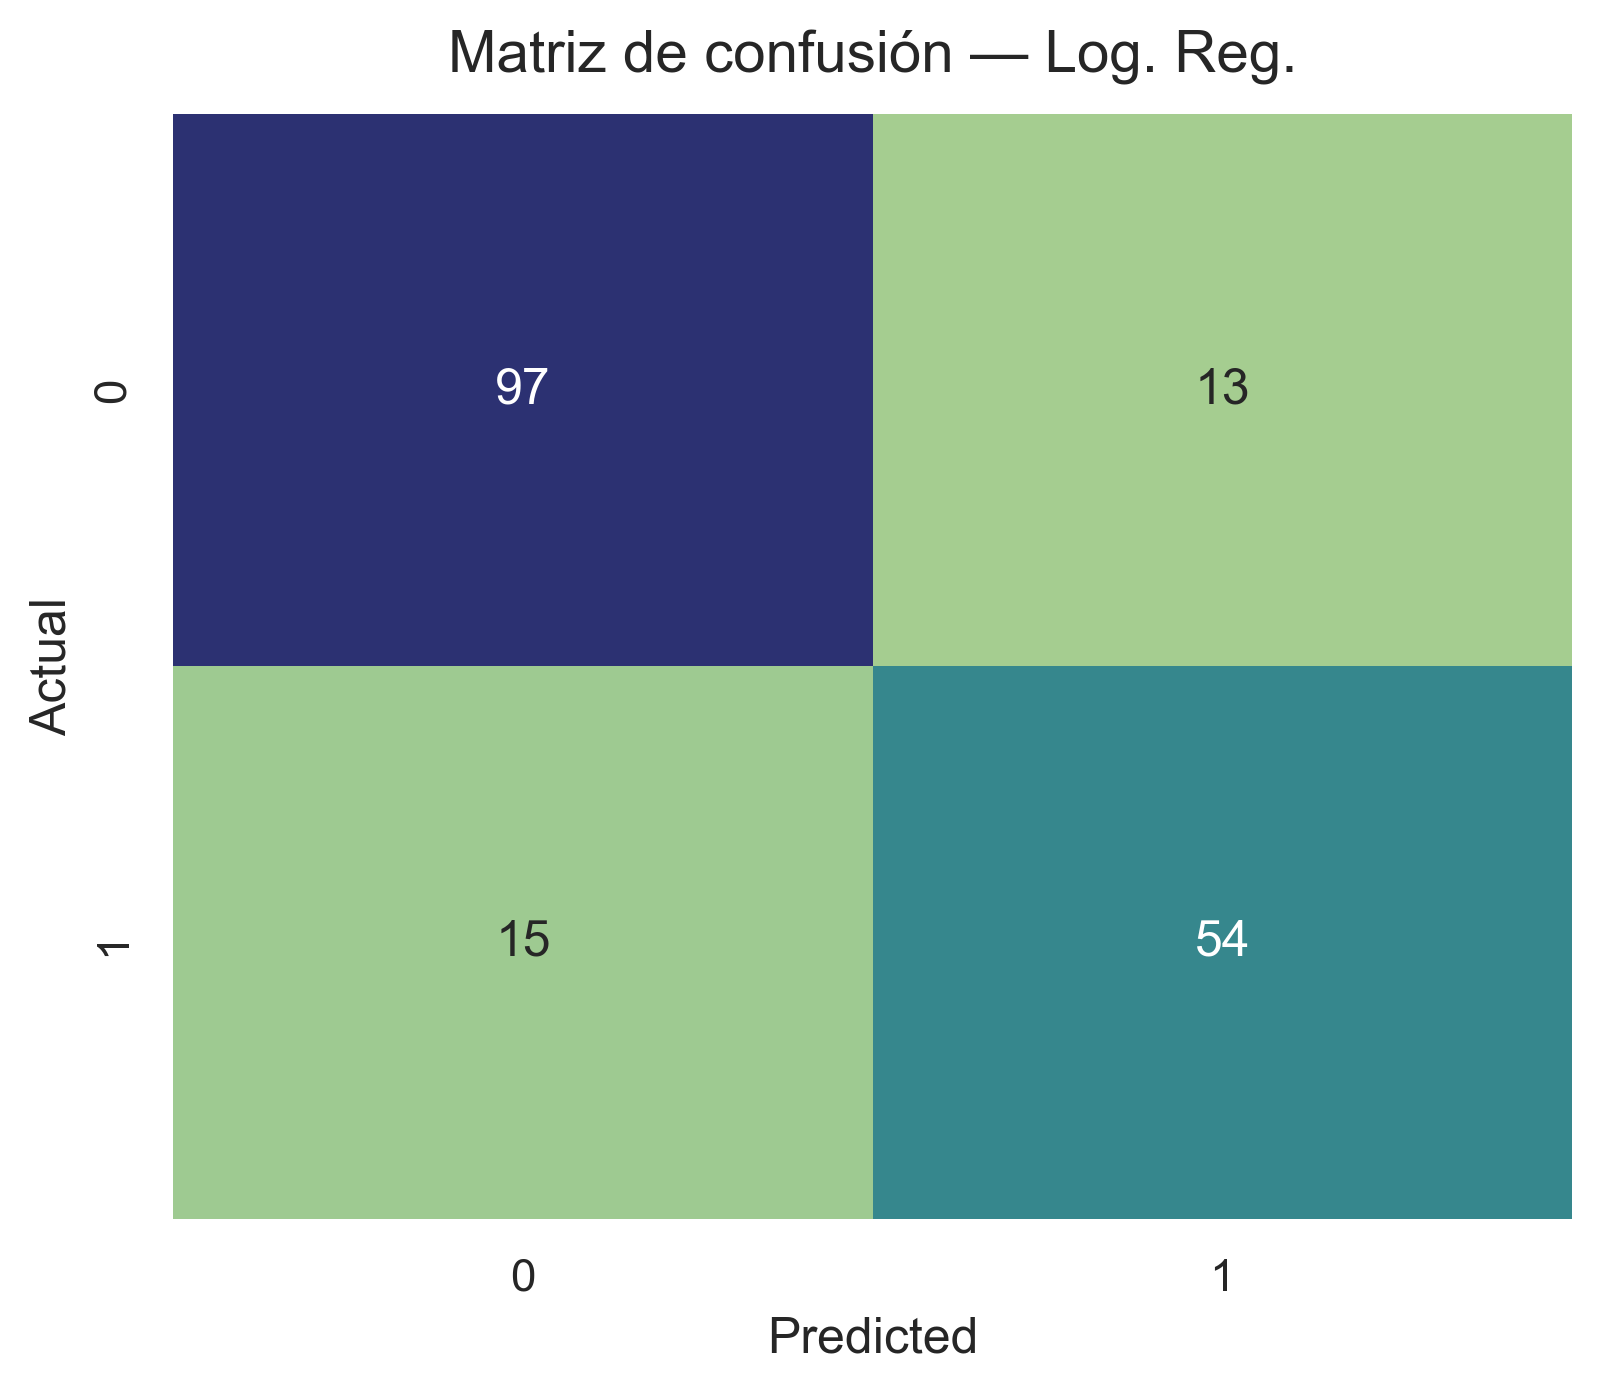

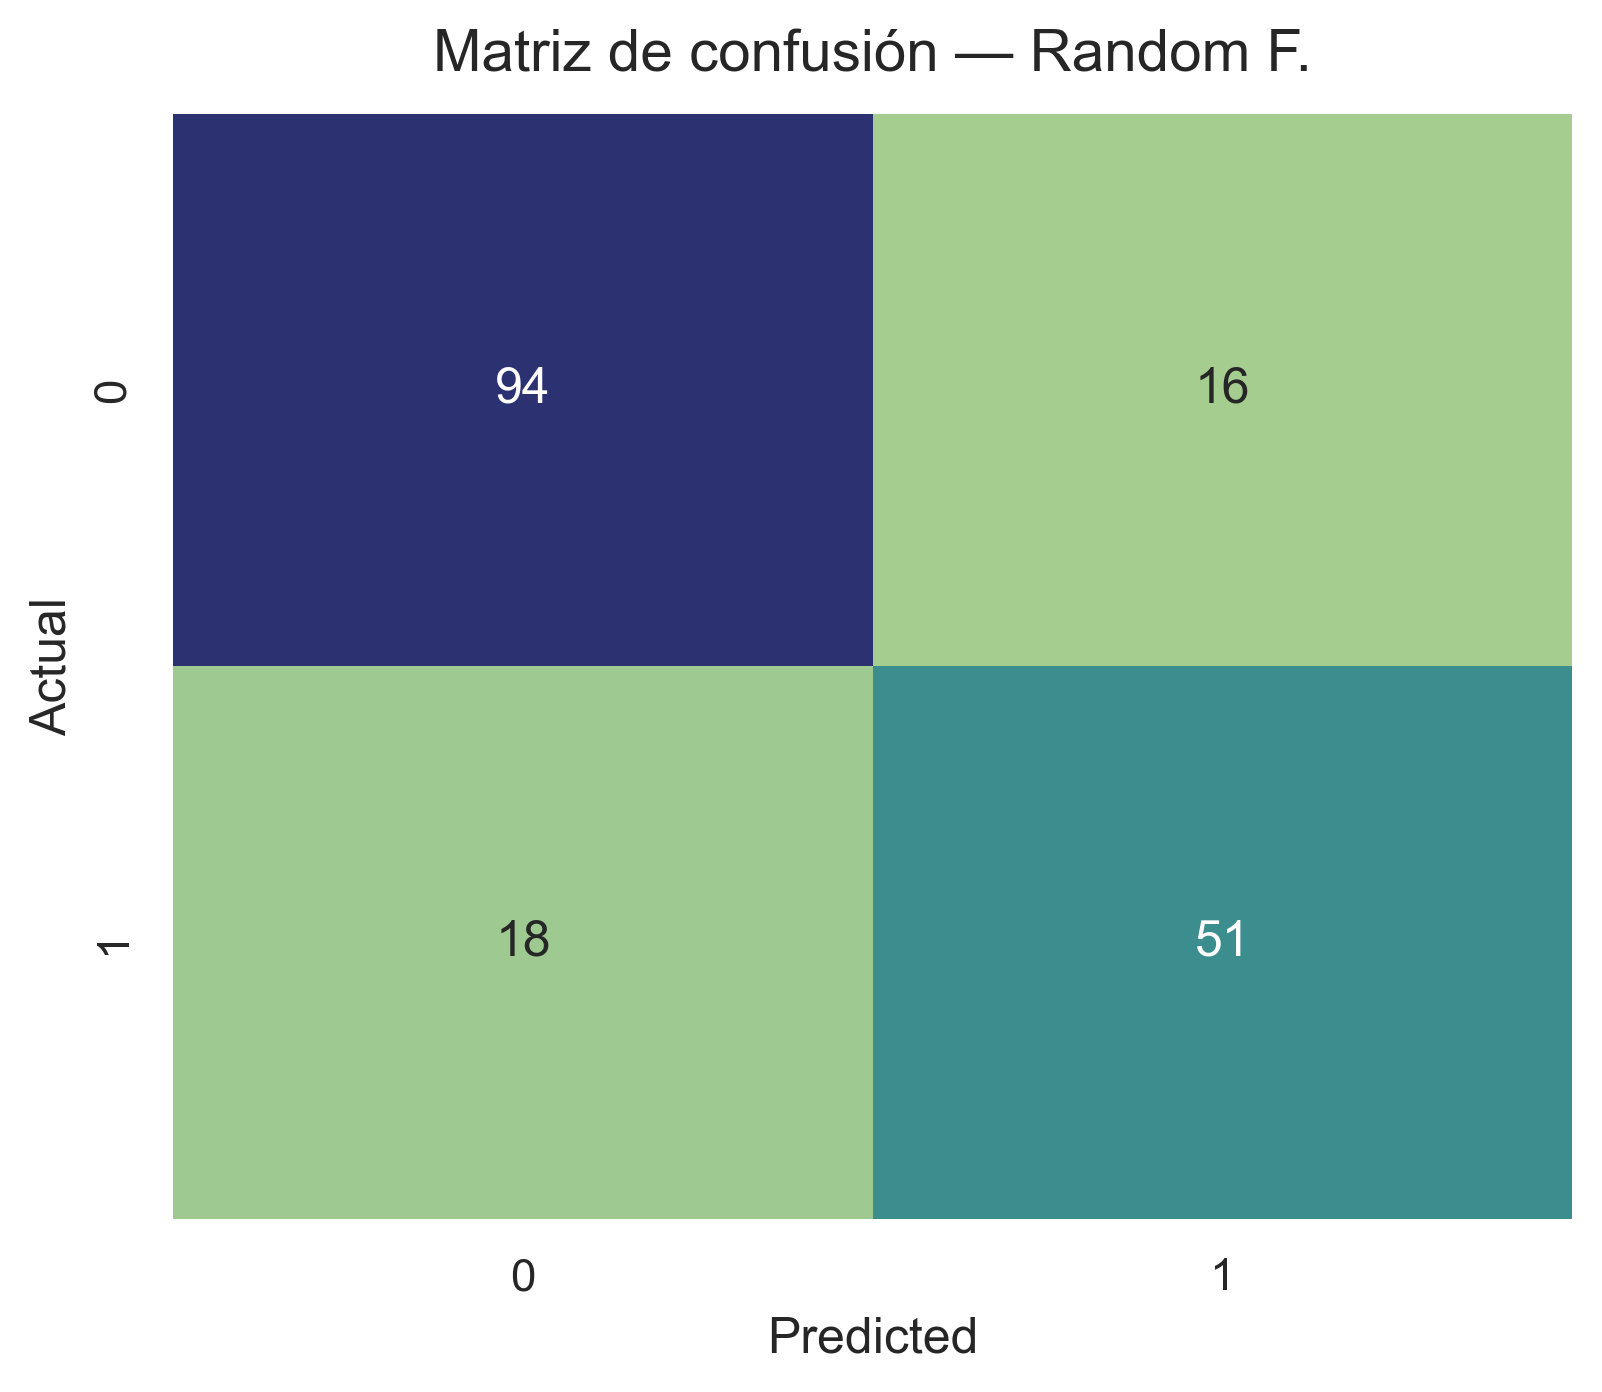

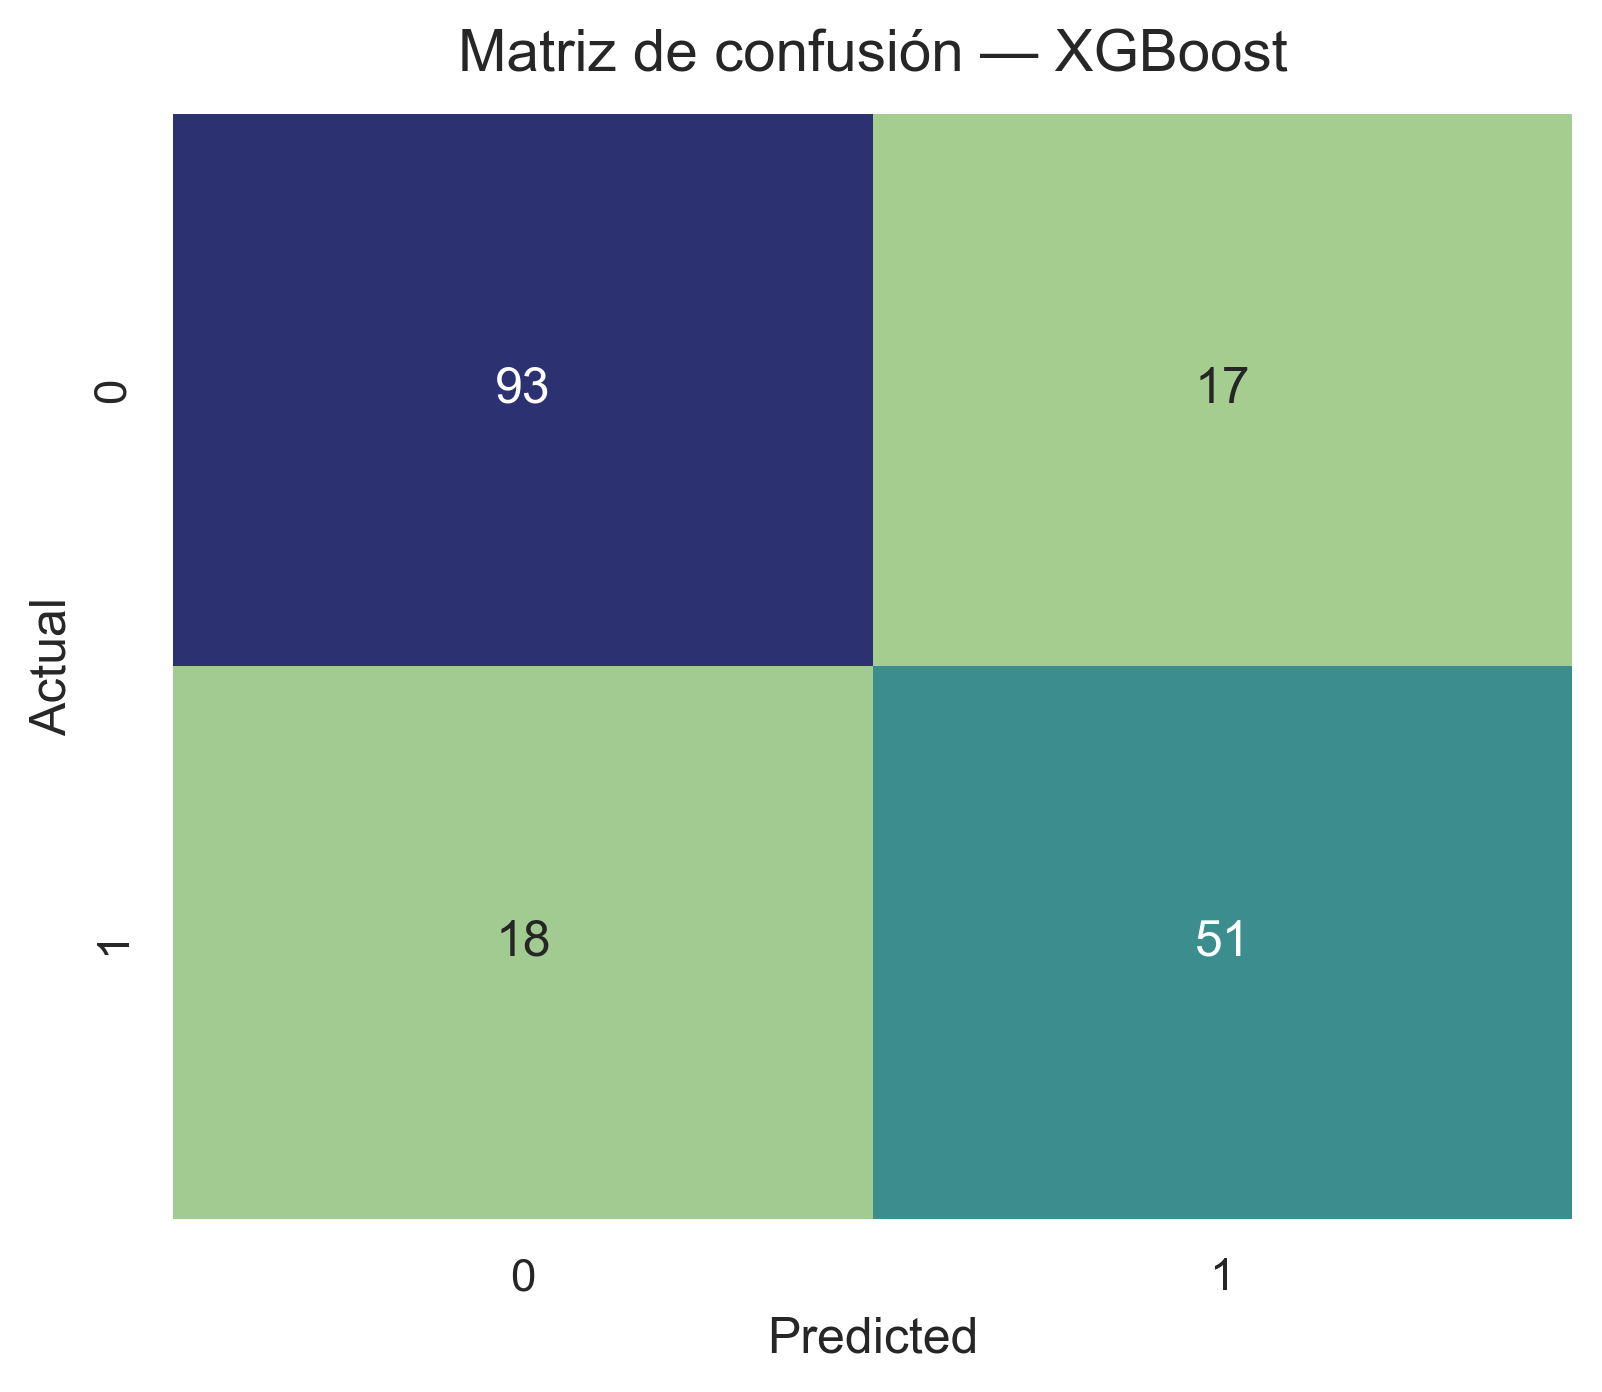

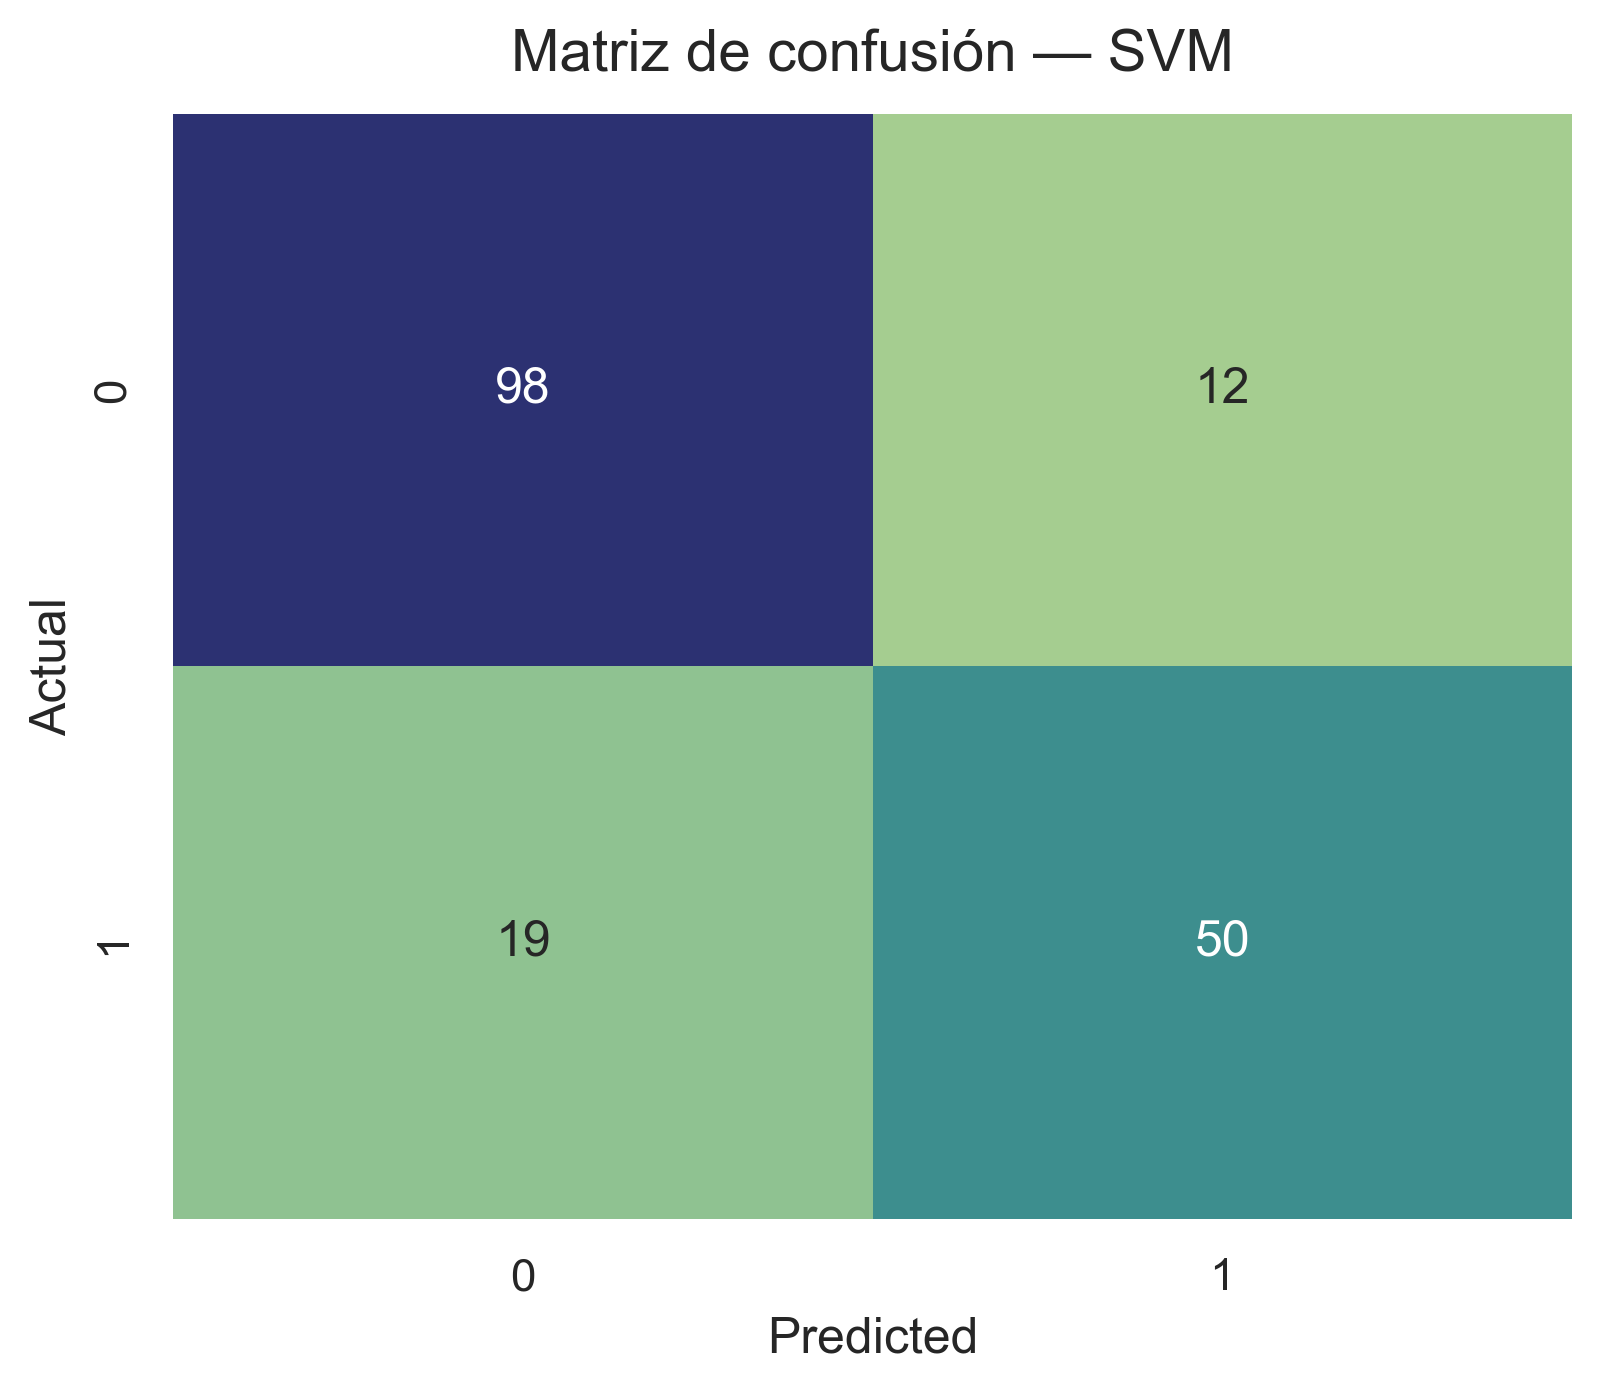

,Modelo,Acc.,Precision,Recall,F1,ROC-AUC
0,Log. Reg.,0.844,0.806,0.783,0.794,0.862
1,SVM,0.827,0.806,0.725,0.763,0.852
2,Random F.,0.810,0.761,0.739,0.750,0.840
3,XGBoost,0.804,0.750,0.739,0.745,0.835


In [24]:
from collections import OrderedDict

results_base = []
roc_curves_data = OrderedDict()
confusion_paths = {}

for name, clf in models.items():
    # Fit en train
    clf.fit(X_train, y_train)
    # Predicciones test
    y_prob = clf.predict_proba(X_test)[:, 1]
    y_pred = (y_prob >= 0.5).astype(int)
    # Métricas
    m = binary_metrics(y_test, y_pred, y_prob)
    results_base.append({"Modelo": name, "Acc.": m["accuracy"], "Precision": m["precision"], "Recall": m["recall"], "F1": m["f1"], "ROC-AUC": m["roc_auc"]})
    # Curva ROC
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_curves_data[name] = (fpr, tpr, m["roc_auc"])
    # Confusion matrix por modelo (no seleccionamos "mejor" aún)
    cm = confusion_matrix(y_test, y_pred, labels=[0,1])
    path_cm = plot_confusion_matrix(
        cm, labels=["0","1"],
        name=f"cm_{name.replace(' ','_').replace('.','')}",
        title=f"Matriz de confusión — {name}",
        caption=f"Matriz de confusión en test para {name}."
    )
    confusion_paths[name] = str(path_cm)
    display(Image(filename=str(path_cm)))

# Tabla 1
df_table1 = pd.DataFrame(results_base)
df_table1_sorted = df_table1.sort_values("ROC-AUC", ascending=False).reset_index(drop=True)
tbl_path = save_metrics_table(
    df_table1_sorted.round(3),
    name="table1_model_comparison",
    description="Tabla 1: Comparación de modelos (test set)."
)
df_table1_sorted.round(3)

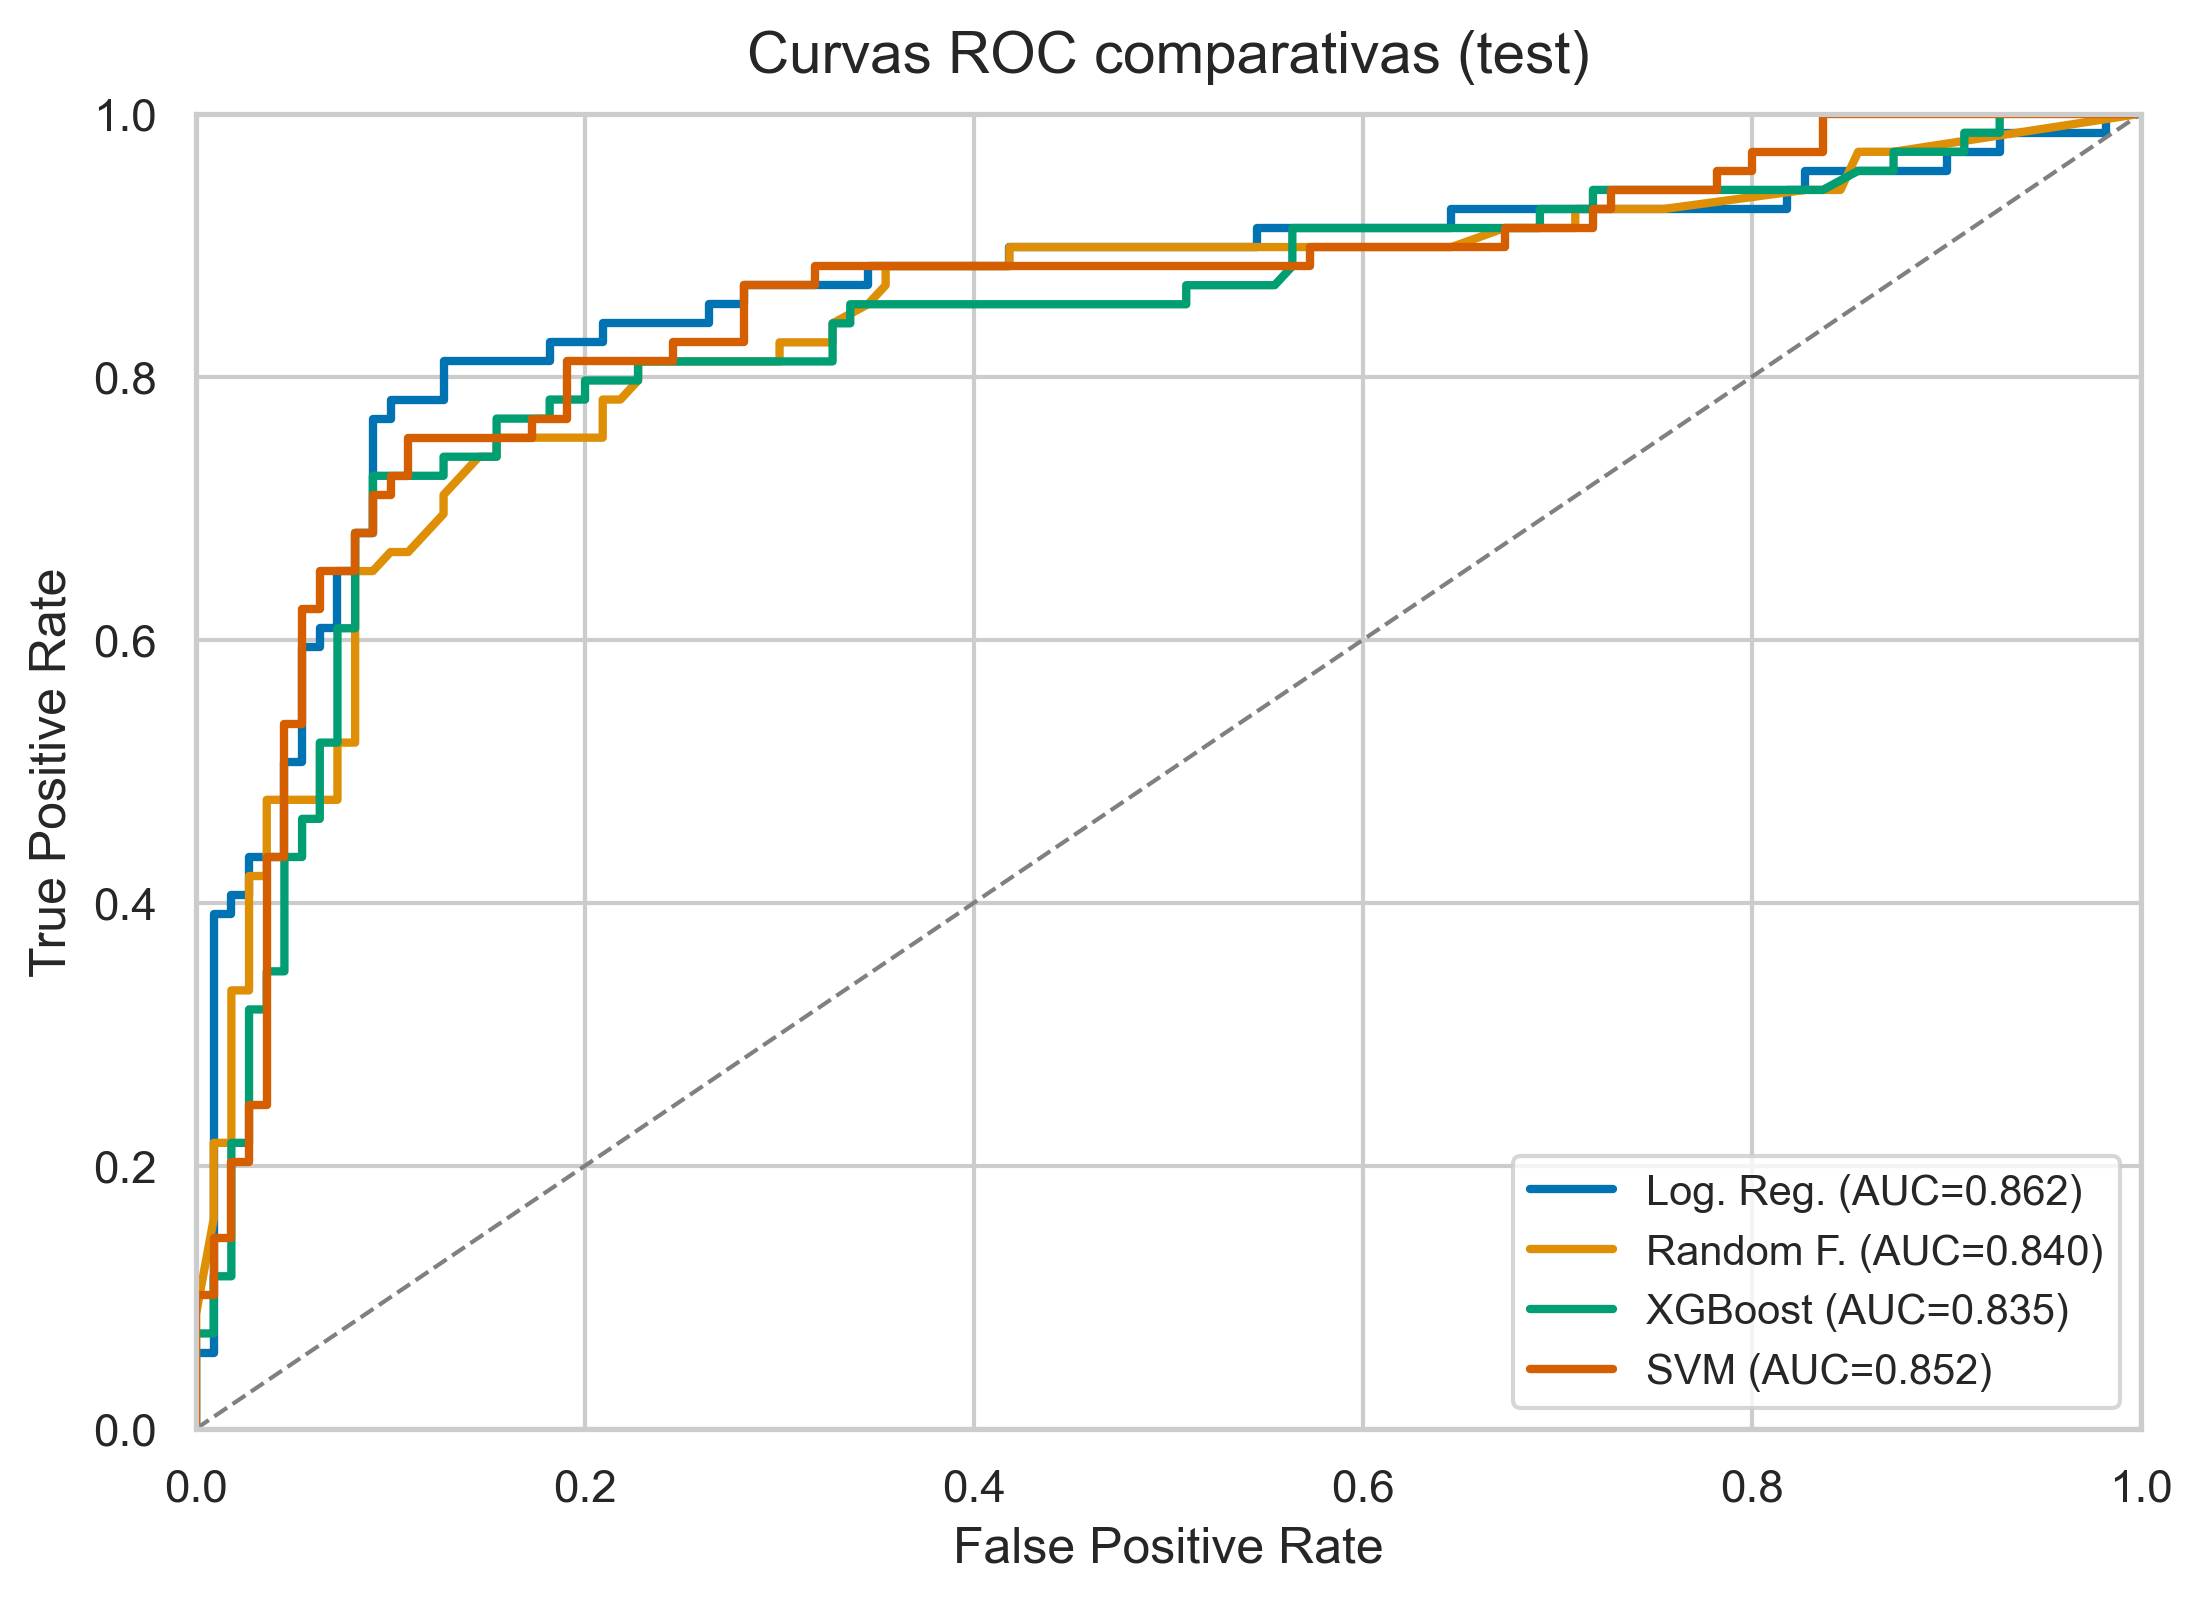

In [25]:
roc_path = plot_roc_curves(
    roc_curves_data,
    name="roc_comparative_all_models",
    title="Curvas ROC comparativas (test)",
    caption="Comparación de curvas ROC para LogReg, Random Forest, XGBoost y SVM en el set de prueba."
)
display(Image(filename=str(roc_path)))

In [26]:
cvk = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_auc = {}
for name, clf in models.items():
    cv_auc[name] = cv_scores_auc(clf, X_train, y_train, cv=5, random_state=42)

# Tabla de p-valores (ttest pareado) entre pares en AUC
pairs = []
names = list(models.keys())
for i in range(len(names)):
    for j in range(i+1, len(names)):
        p = ttest_paired(cv_auc[names[i]], cv_auc[names[j]])
        pairs.append({"Modelo_A": names[i], "Modelo_B": names[j], "p_value_ttest_AUC": p})

df_stats = pd.DataFrame(pairs).sort_values("p_value_ttest_AUC")
stats_tbl_path = save_metrics_table(
    df_stats.round(4), name="stats_differences_models",
    description="Análisis de diferencias: t-test pareado sobre AUC en CV (5 folds)."
)
df_stats.round(4)

,Modelo_A,Modelo_B,p_value_ttest_AUC
3,Random F.,XGBoost,0.0497
5,XGBoost,SVM,0.0602
1,Log. Reg.,XGBoost,0.1031
2,Log. Reg.,SVM,0.3062
4,Random F.,SVM,0.4146
0,Log. Reg.,Random F.,0.8083


In [27]:
# Recalcular predicciones en test para coherencia
preds_test = {}
for name, clf in models.items():
    y_prob = clf.predict_proba(X_test)[:, 1]
    y_pred = (y_prob >= 0.5).astype(int)
    preds_test[name] = y_pred

pairs_mcnemar = []
for i in range(len(names)):
    for j in range(i+1, len(names)):
        p = mcnemar_pvalue(y_test, preds_test[names[i]], preds_test[names[j]])
        pairs_mcnemar.append({"Modelo_A": names[i], "Modelo_B": names[j], "p_value_McNemar": p})

df_mcnemar = pd.DataFrame(pairs_mcnemar).sort_values("p_value_McNemar")
mcn_tbl_path = save_metrics_table(
    df_mcnemar.round(4), name="stats_mcnemar_models",
    description="Análisis de diferencias: McNemar en test (comparación de etiquetas)."
)
df_mcnemar.round(4)

,Modelo_A,Modelo_B,p_value_McNemar
1,Log. Reg.,XGBoost,0.2109
0,Log. Reg.,Random F.,0.2386
2,Log. Reg.,SVM,0.5050
5,XGBoost,SVM,0.5403
4,Random F.,SVM,0.6767
3,Random F.,XGBoost,1.0000


In [28]:
best_models = {}
search_summaries = []

for name, base_model in models.items():
    # Strategy: combinamos GridSearchCV (pequeño) + RandomizedSearchCV (más amplio)
    cvk = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # GridSearchCV
    grid = GridSearchCV(
        estimator=base_model, param_grid=param_grids[name],
        scoring="roc_auc", cv=cvk, n_jobs=None, refit=True
    )
    grid.fit(X_train, y_train)
    # RandomizedSearchCV
    rnd = RandomizedSearchCV(
        estimator=base_model, param_distributions=param_distributions[name],
        n_iter=30, scoring="roc_auc", cv=cvk, random_state=42, n_jobs=None, refit=True
    )
    rnd.fit(X_train, y_train)

    # Elegimos el MEJOR **dentro del modelo** por AUC CV (no comparamos con otros modelos aquí)
    if grid.best_score_ >= rnd.best_score_:
        best_cv = grid.best_score_; best_est = grid.best_estimator_; best_params = grid.best_params_; search_type = "GridSearchCV"
    else:
        best_cv = rnd.best_score_; best_est = rnd.best_estimator_; best_params = rnd.best_params_; search_type = "RandomizedSearchCV"

    # Métricas en test con el mejor estimador de este modelo
    y_prob = best_est.predict_proba(X_test)[:, 1]
    y_pred = (y_prob >= 0.5).astype(int)
    m = binary_metrics(y_test, y_pred, y_prob)

    # Guardamos resumen
    best_models[name] = {
        "search_type": search_type,
        "best_params": best_params,
        "cv_auc_mean": float(best_cv),
        "test_metrics": m
    }
    search_summaries.append({
        "Modelo": name,
        "Search": search_type,
        "CV_ROC-AUC": best_cv,
        "Test_ROC-AUC": m["roc_auc"],
        "Acc.": m["accuracy"], "Precision": m["precision"], "Recall": m["recall"], "F1": m["f1"]
    })

# Tabla resumen de segunda corrida
df_search = pd.DataFrame(search_summaries).sort_values("Test_ROC-AUC", ascending=False)
search_tbl_path = save_metrics_table(
    df_search.round(4), name="table_search_summary",
    description="Segunda corrida por modelo con GridSearchCV/RandomizedSearchCV. Métricas en test del mejor estimador por modelo."
)
df_search.round(4)

,Modelo,Search,CV_ROC-AUC,Test_ROC-AUC,Acc.,Precision,Recall,F1
0,Log. Reg.,RandomizedSearchCV,0.8750,0.8602,0.8268,0.7969,0.7391,0.7669
1,Random F.,GridSearchCV,0.8943,0.8487,0.8156,0.8000,0.6957,0.7442
3,SVM,RandomizedSearchCV,0.8705,0.8469,0.7877,0.7385,0.6957,0.7164
2,XGBoost,RandomizedSearchCV,0.9008,0.8288,0.7933,0.7581,0.6812,0.7176


In [29]:
# Base (ya calculado en 'results_base')
df_base_all = pd.DataFrame(results_base).rename(columns={
    "Acc.": "Acc",
    "ROC-AUC": "ROC_AUC"
})
df_base_all.insert(1, "Variant", "Base")  # columna Variant
df_base_all["CV_ROC_AUC"] = np.nan  # sin CV para base en esta tabla 

# Tuned (resumen de la búsqueda por modelo 'search_summaries')
df_tuned_all = pd.DataFrame(search_summaries).rename(columns={
    "CV_ROC-AUC": "CV_ROC_AUC",
    "Test_ROC-AUC": "ROC_AUC",
    "Acc.": "Acc"
})
df_tuned_all.insert(1, "Variant", "Tuned")  # columna Variant
df_tuned_all.rename(columns={"Search": "SearchType"}, inplace=True)

# Selección de columnas comunes y orden
cols = ["Modelo", "Variant", "Acc", "Precision", "Recall", "F1", "ROC_AUC", "CV_ROC_AUC", "SearchType"]
for c in cols:
    if c not in df_base_all.columns:
        df_base_all[c] = np.nan
    if c not in df_tuned_all.columns:
        df_tuned_all[c] = np.nan

df_all_models = pd.concat([df_base_all[cols], df_tuned_all[cols]], axis=0, ignore_index=True)

# Orden por ROC_AUC (test) descendente y luego por Variant (Tuned primero)
df_all_models["Variant"] = pd.Categorical(df_all_models["Variant"], categories=["Tuned","Base"], ordered=True)
df_all_models = df_all_models.sort_values(["ROC_AUC","Variant"], ascending=[False, True]).reset_index(drop=True)

# Guardar y mostrar
all_tbl_path = save_metrics_table(
    df_all_models.round(3),
    name="table_all_models_comparison",
    description="Comparación completa de modelos (Base y Tuned) con métricas de test y CV-AUC cuando aplica."
)
display(df_all_models.round(3))

,Modelo,Variant,Acc,Precision,Recall,F1,ROC_AUC,CV_ROC_AUC,SearchType
0,Log. Reg.,Base,0.844,0.806,0.783,0.794,0.862,NaN,NaN
1,Log. Reg.,Tuned,0.827,0.797,0.739,0.767,0.860,0.875,RandomizedSearchCV
2,SVM,Base,0.827,0.806,0.725,0.763,0.852,NaN,NaN
3,Random F.,Tuned,0.816,0.800,0.696,0.744,0.849,0.894,GridSearchCV
4,SVM,Tuned,0.788,0.738,0.696,0.716,0.847,0.870,RandomizedSearchCV
5,Random F.,Base,0.810,0.761,0.739,0.750,0.840,NaN,NaN
6,XGBoost,Base,0.804,0.750,0.739,0.745,0.835,NaN,NaN
7,XGBoost,Tuned,0.793,0.758,0.681,0.718,0.829,0.901,RandomizedSearchCV


In [30]:
out_json = {
    "experiment": "baseline_and_search_per_model",
    "notes": "Comparación de modelos y búsqueda de hiperparámetros por modelo.",
    "table1_path": str(tbl_path),
    "roc_figure_path": str(roc_path),
    "confusion_paths": {k: v for k, v in confusion_paths.items()},
    "stats_ttest_path": str(stats_tbl_path),
    "stats_mcnemar_path": str(mcn_tbl_path),
    "search_summary_path": str(search_tbl_path),
    "best_models": best_models  
}
save_metrics_json(out_json, "results/metrics.json")

WindowsPath('C:/Users/luigu/OneDrive/Escritorio/Titanic_MLProject/results/metrics.json')

## Decisión sobre el modelo

Tras comparar los cuatro modelos (Regresión Logística, Random Forest, XGBoost y SVM), se observa que:

- **Regresión Logística (base)** obtiene el **mejor AUC en test (0.862)** y mantiene un equilibrio favorable entre **precision (0.81)** y **recall (0.78)**.  
- Los demás modelos presentan desempeños muy cercanos en ROC-AUC, pero tienden a perder recall o a sobreajustar durante la búsqueda de hiperparámetros.  
- Los análisis estadísticos (t-test y McNemar) muestran que **las diferencias no son estadísticamente significativas**, lo que refuerza que todos los modelos son comparables en este dataset relativamente pequeño.  
- Dada la **simplicidad, interpretabilidad y estabilidad** de la Regresión Logística, se elige como **modelo de referencia** para la siguiente etapa.  
- Adicionalmente, se considerará evaluar variantes con **balanceo de clases** (`class_weight='balanced'`) y **ajuste de umbral de decisión**, con el objetivo de mejorar el **recall** del grupo positivo (supervivientes).

**Regresión Logística** se selecciona como modelo central, priorizando **interpretabilidad** y **robustez**, con exploraciones posteriores para mitigar el desbalance de clases y optimizar recall.

In [31]:
from sklearn.linear_model import LogisticRegression
from src.evaluation import pr_auc, sweep_thresholds, choose_thresholds, metrics_from_threshold, save_metrics_table
from src.visualization import plot_pr_curve, plot_threshold_tradeoff, plot_confusion_matrix

# Entrena LogReg base y balanceada sobre las representaciones ya transformadas
logreg_base = LogisticRegression(max_iter=2000, solver="lbfgs")
logreg_base.fit(X_train, y_train)
proba_base = logreg_base.predict_proba(X_test)[:, 1]

logreg_bal = LogisticRegression(max_iter=2000, solver="lbfgs", class_weight="balanced")
logreg_bal.fit(X_train, y_train)
proba_bal = logreg_bal.predict_proba(X_test)[:, 1]

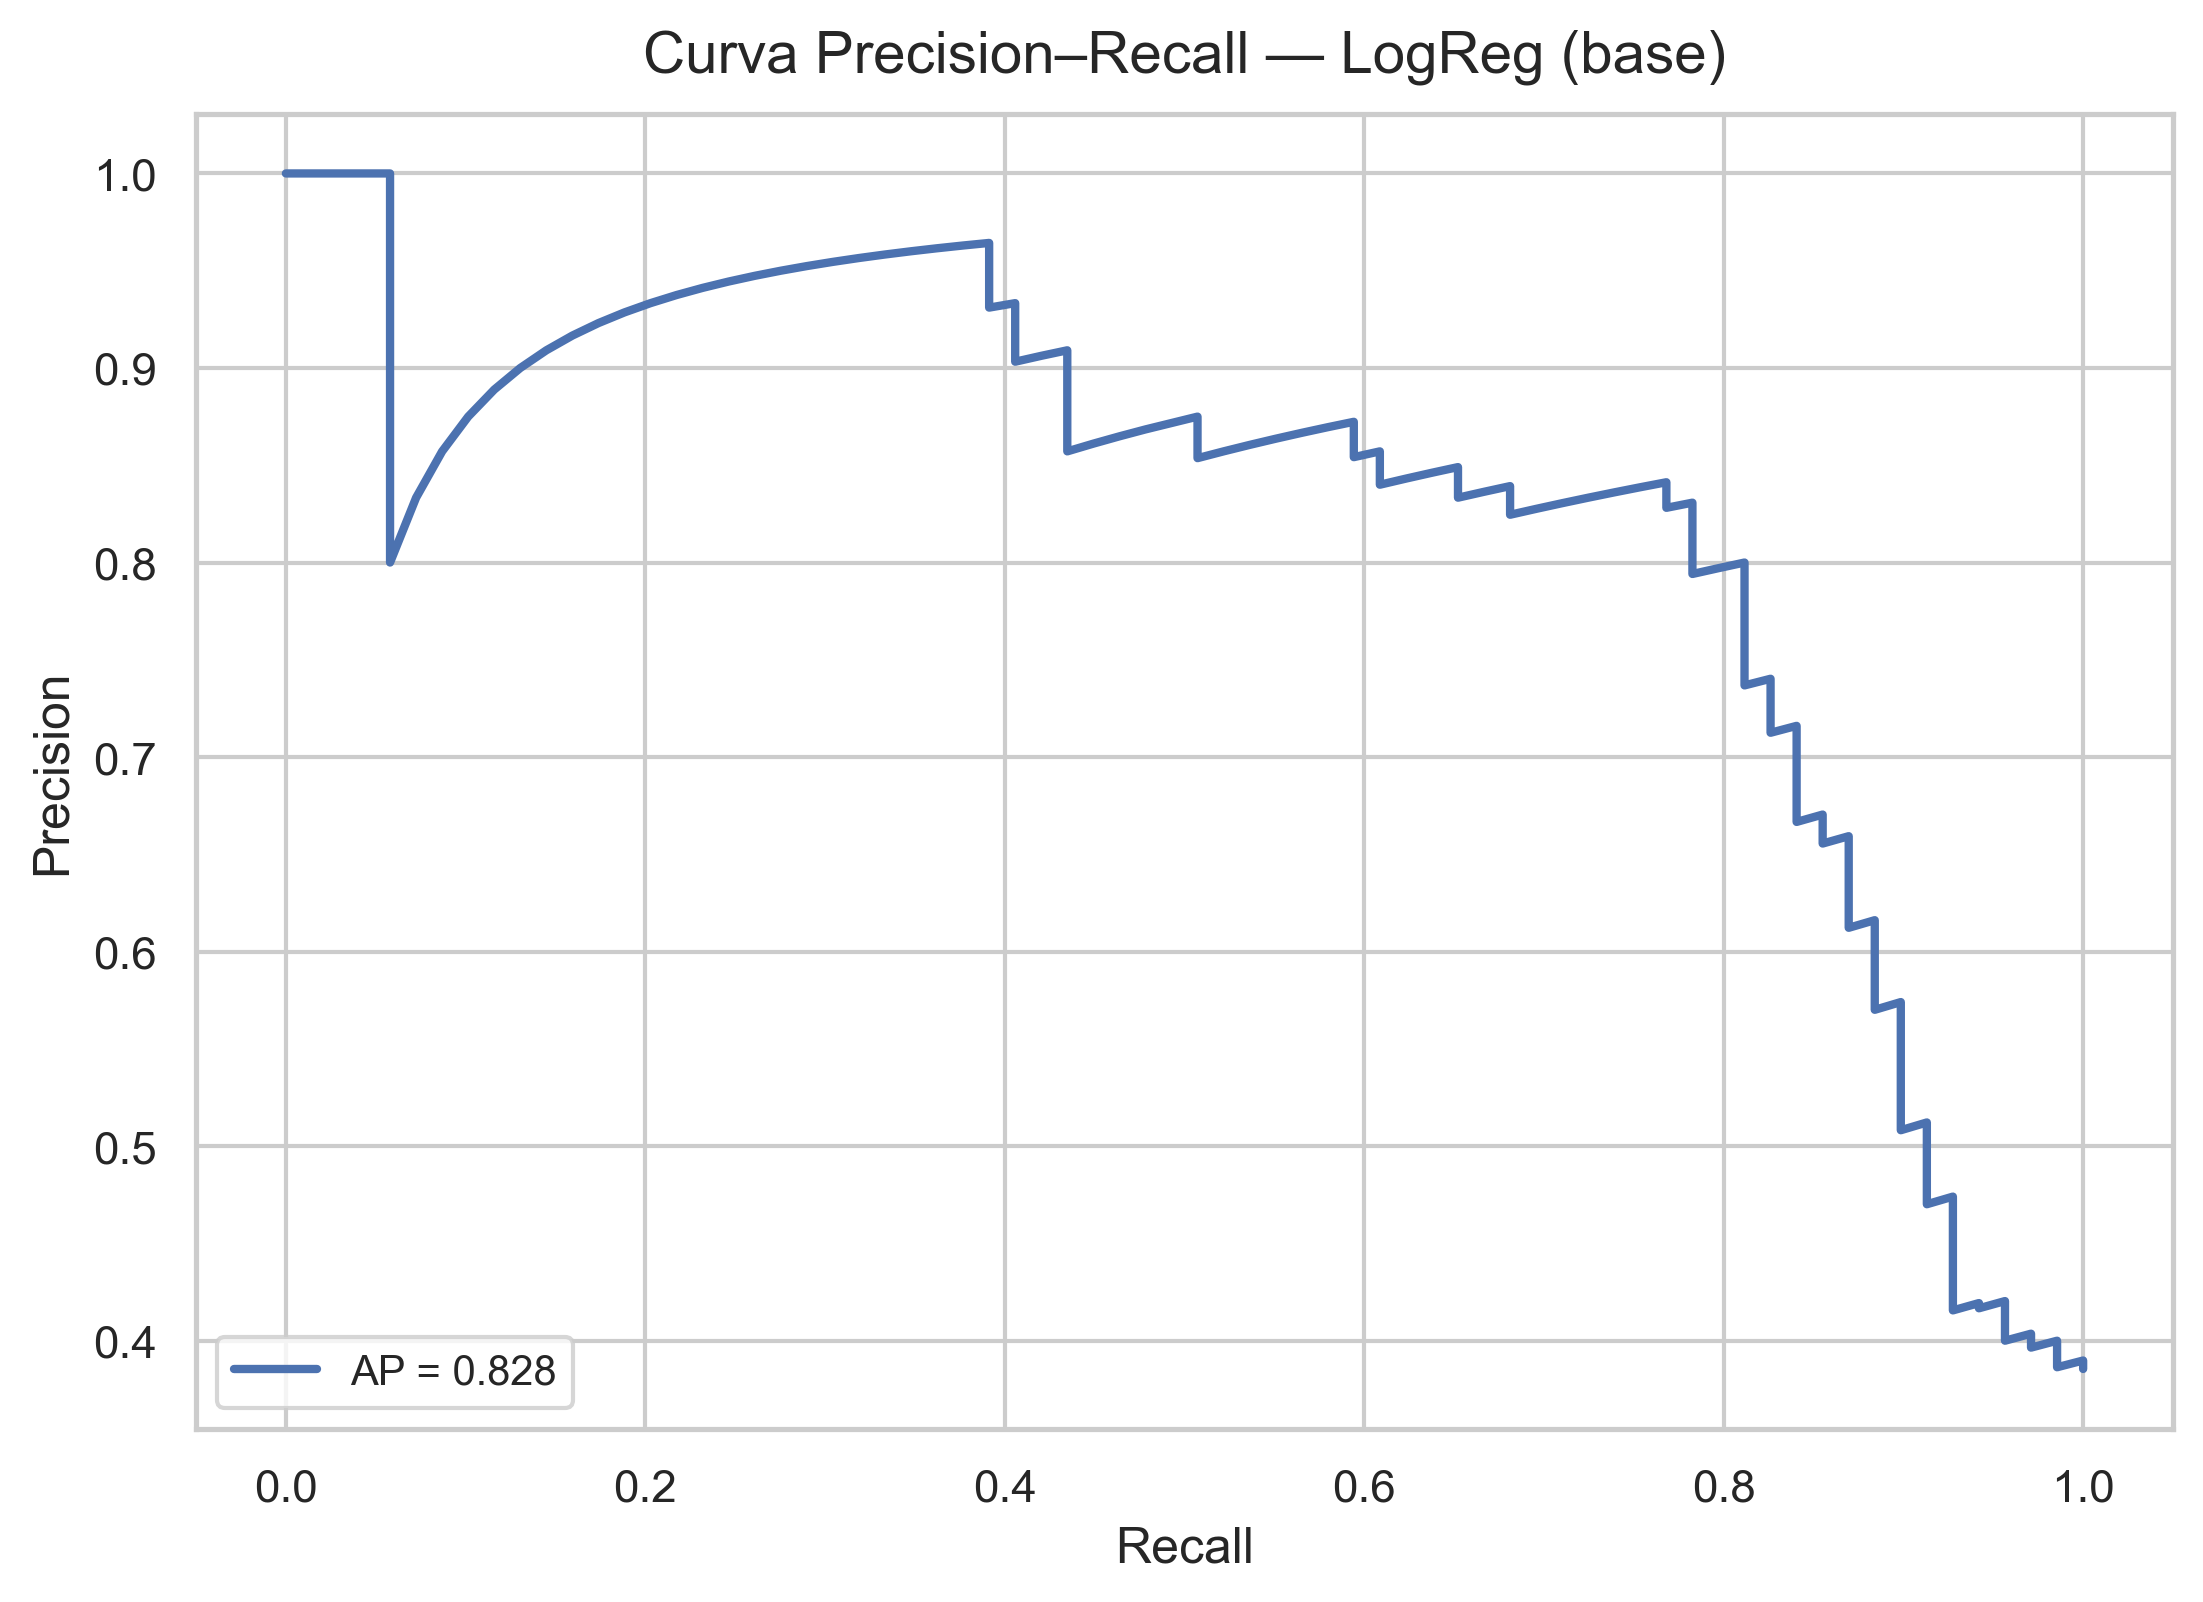

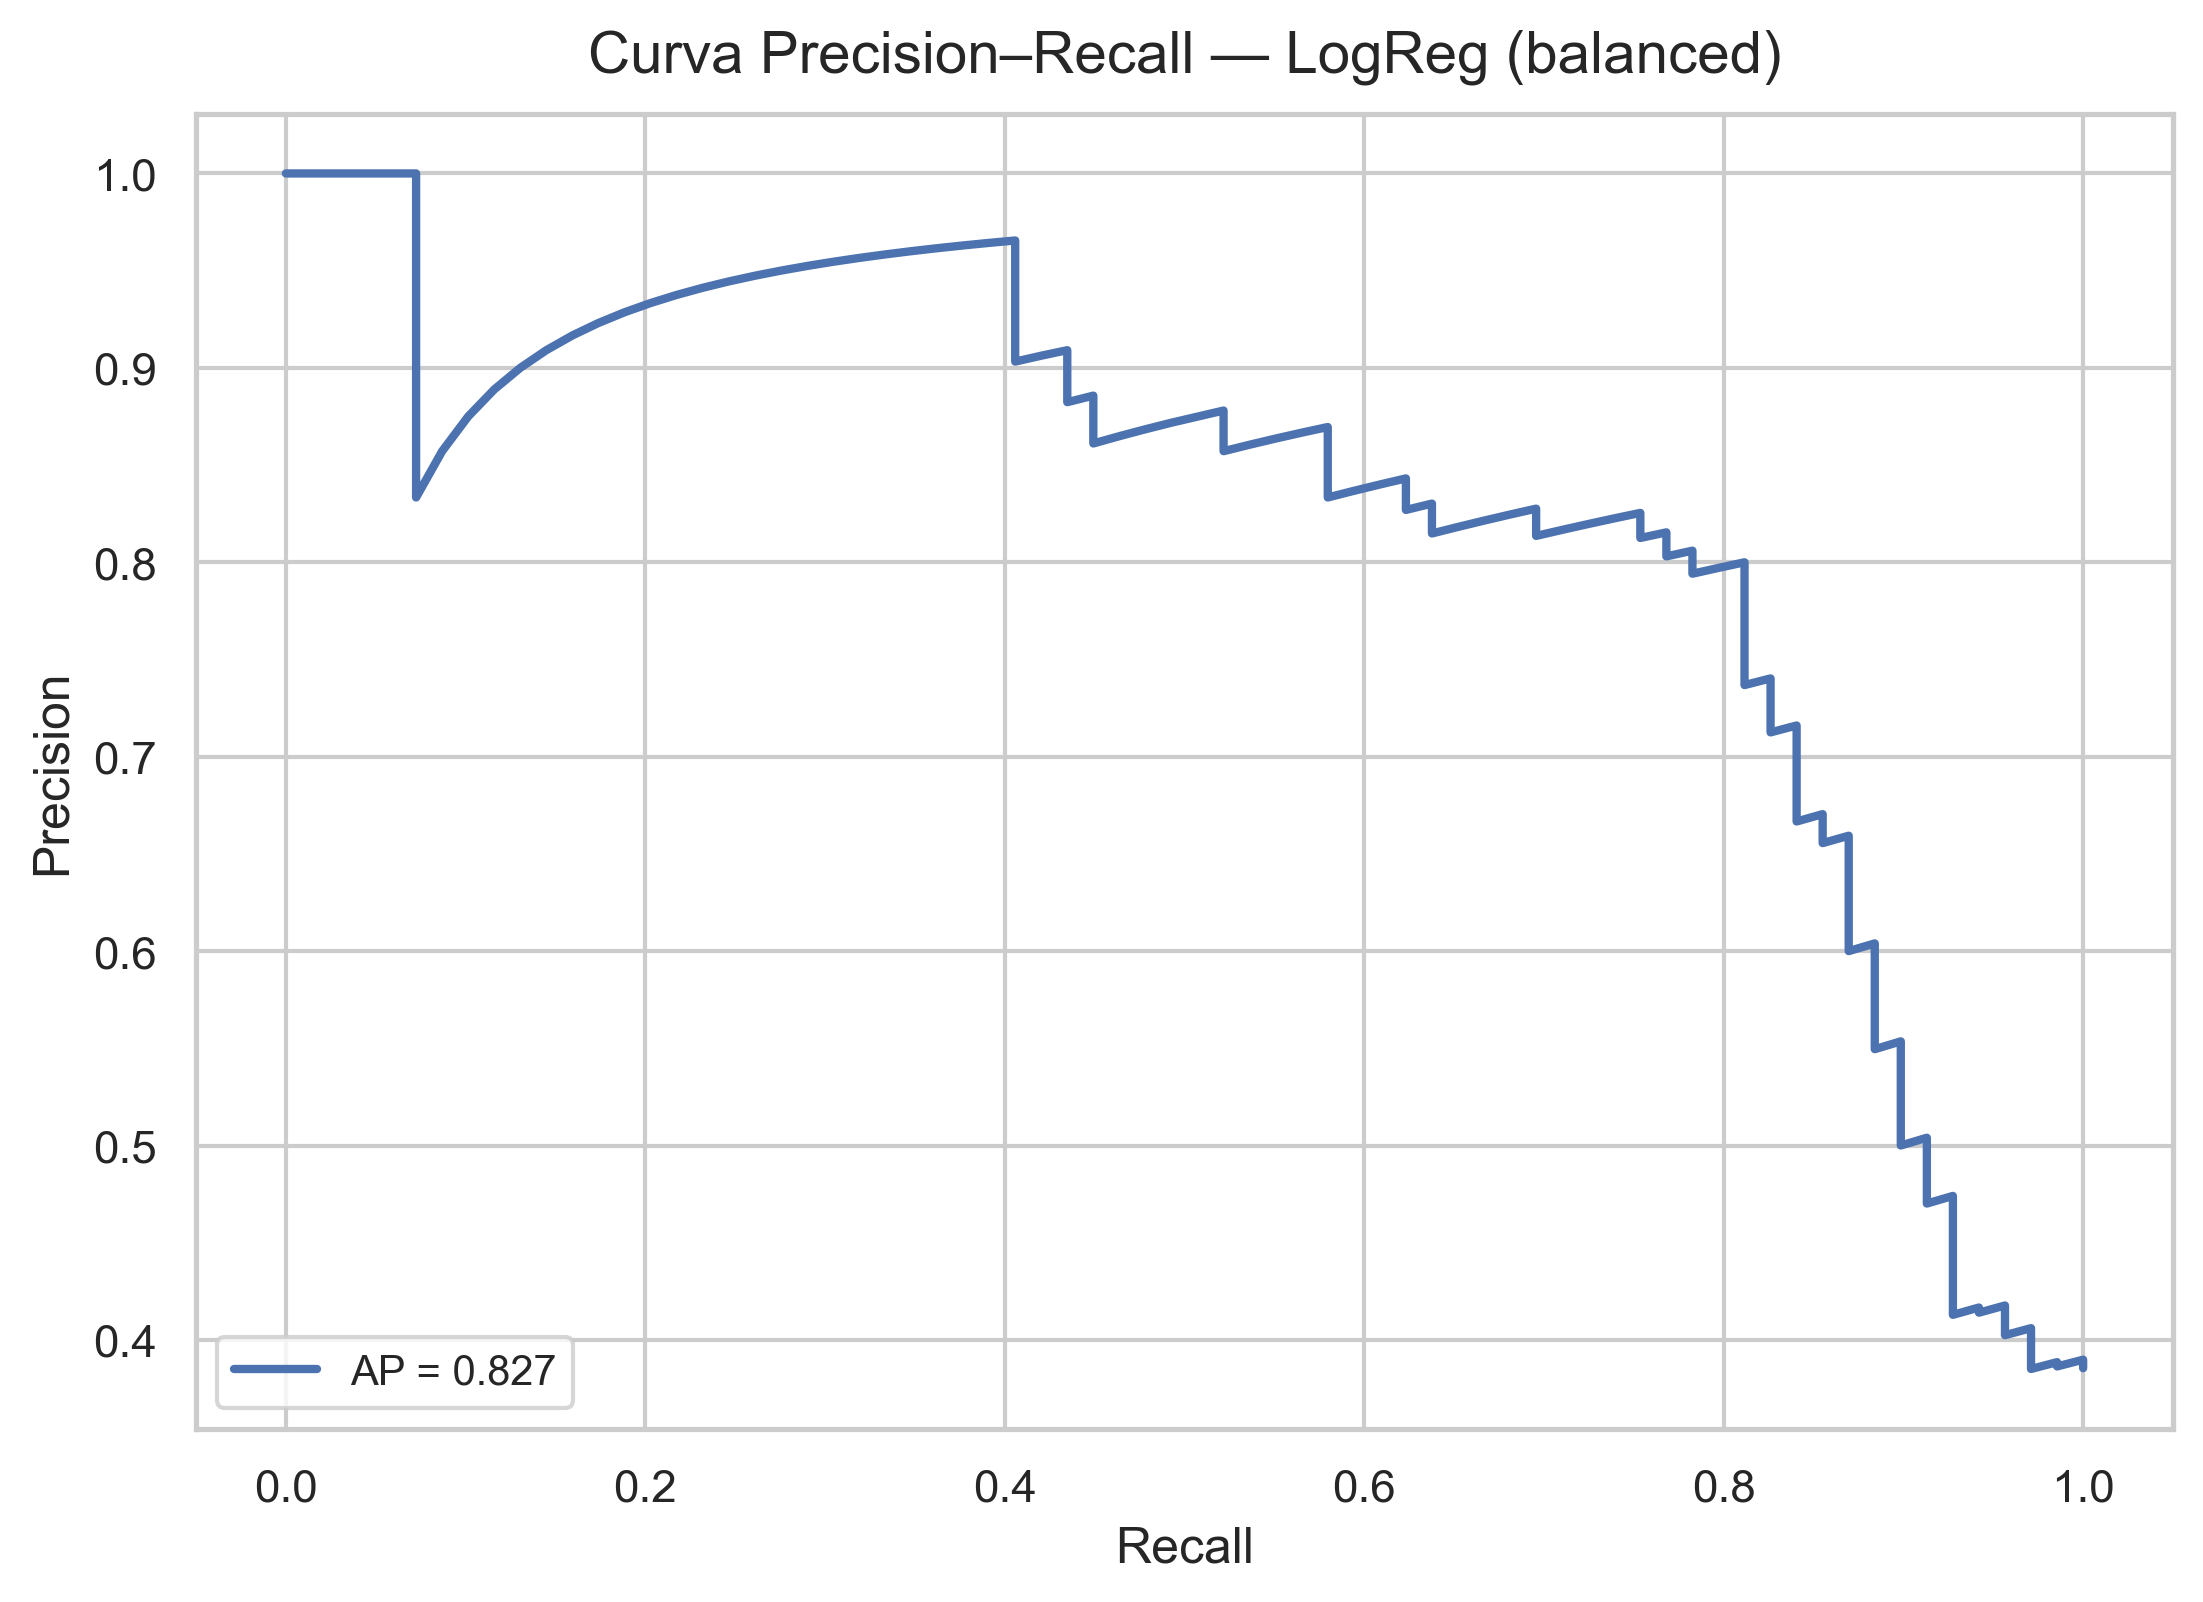

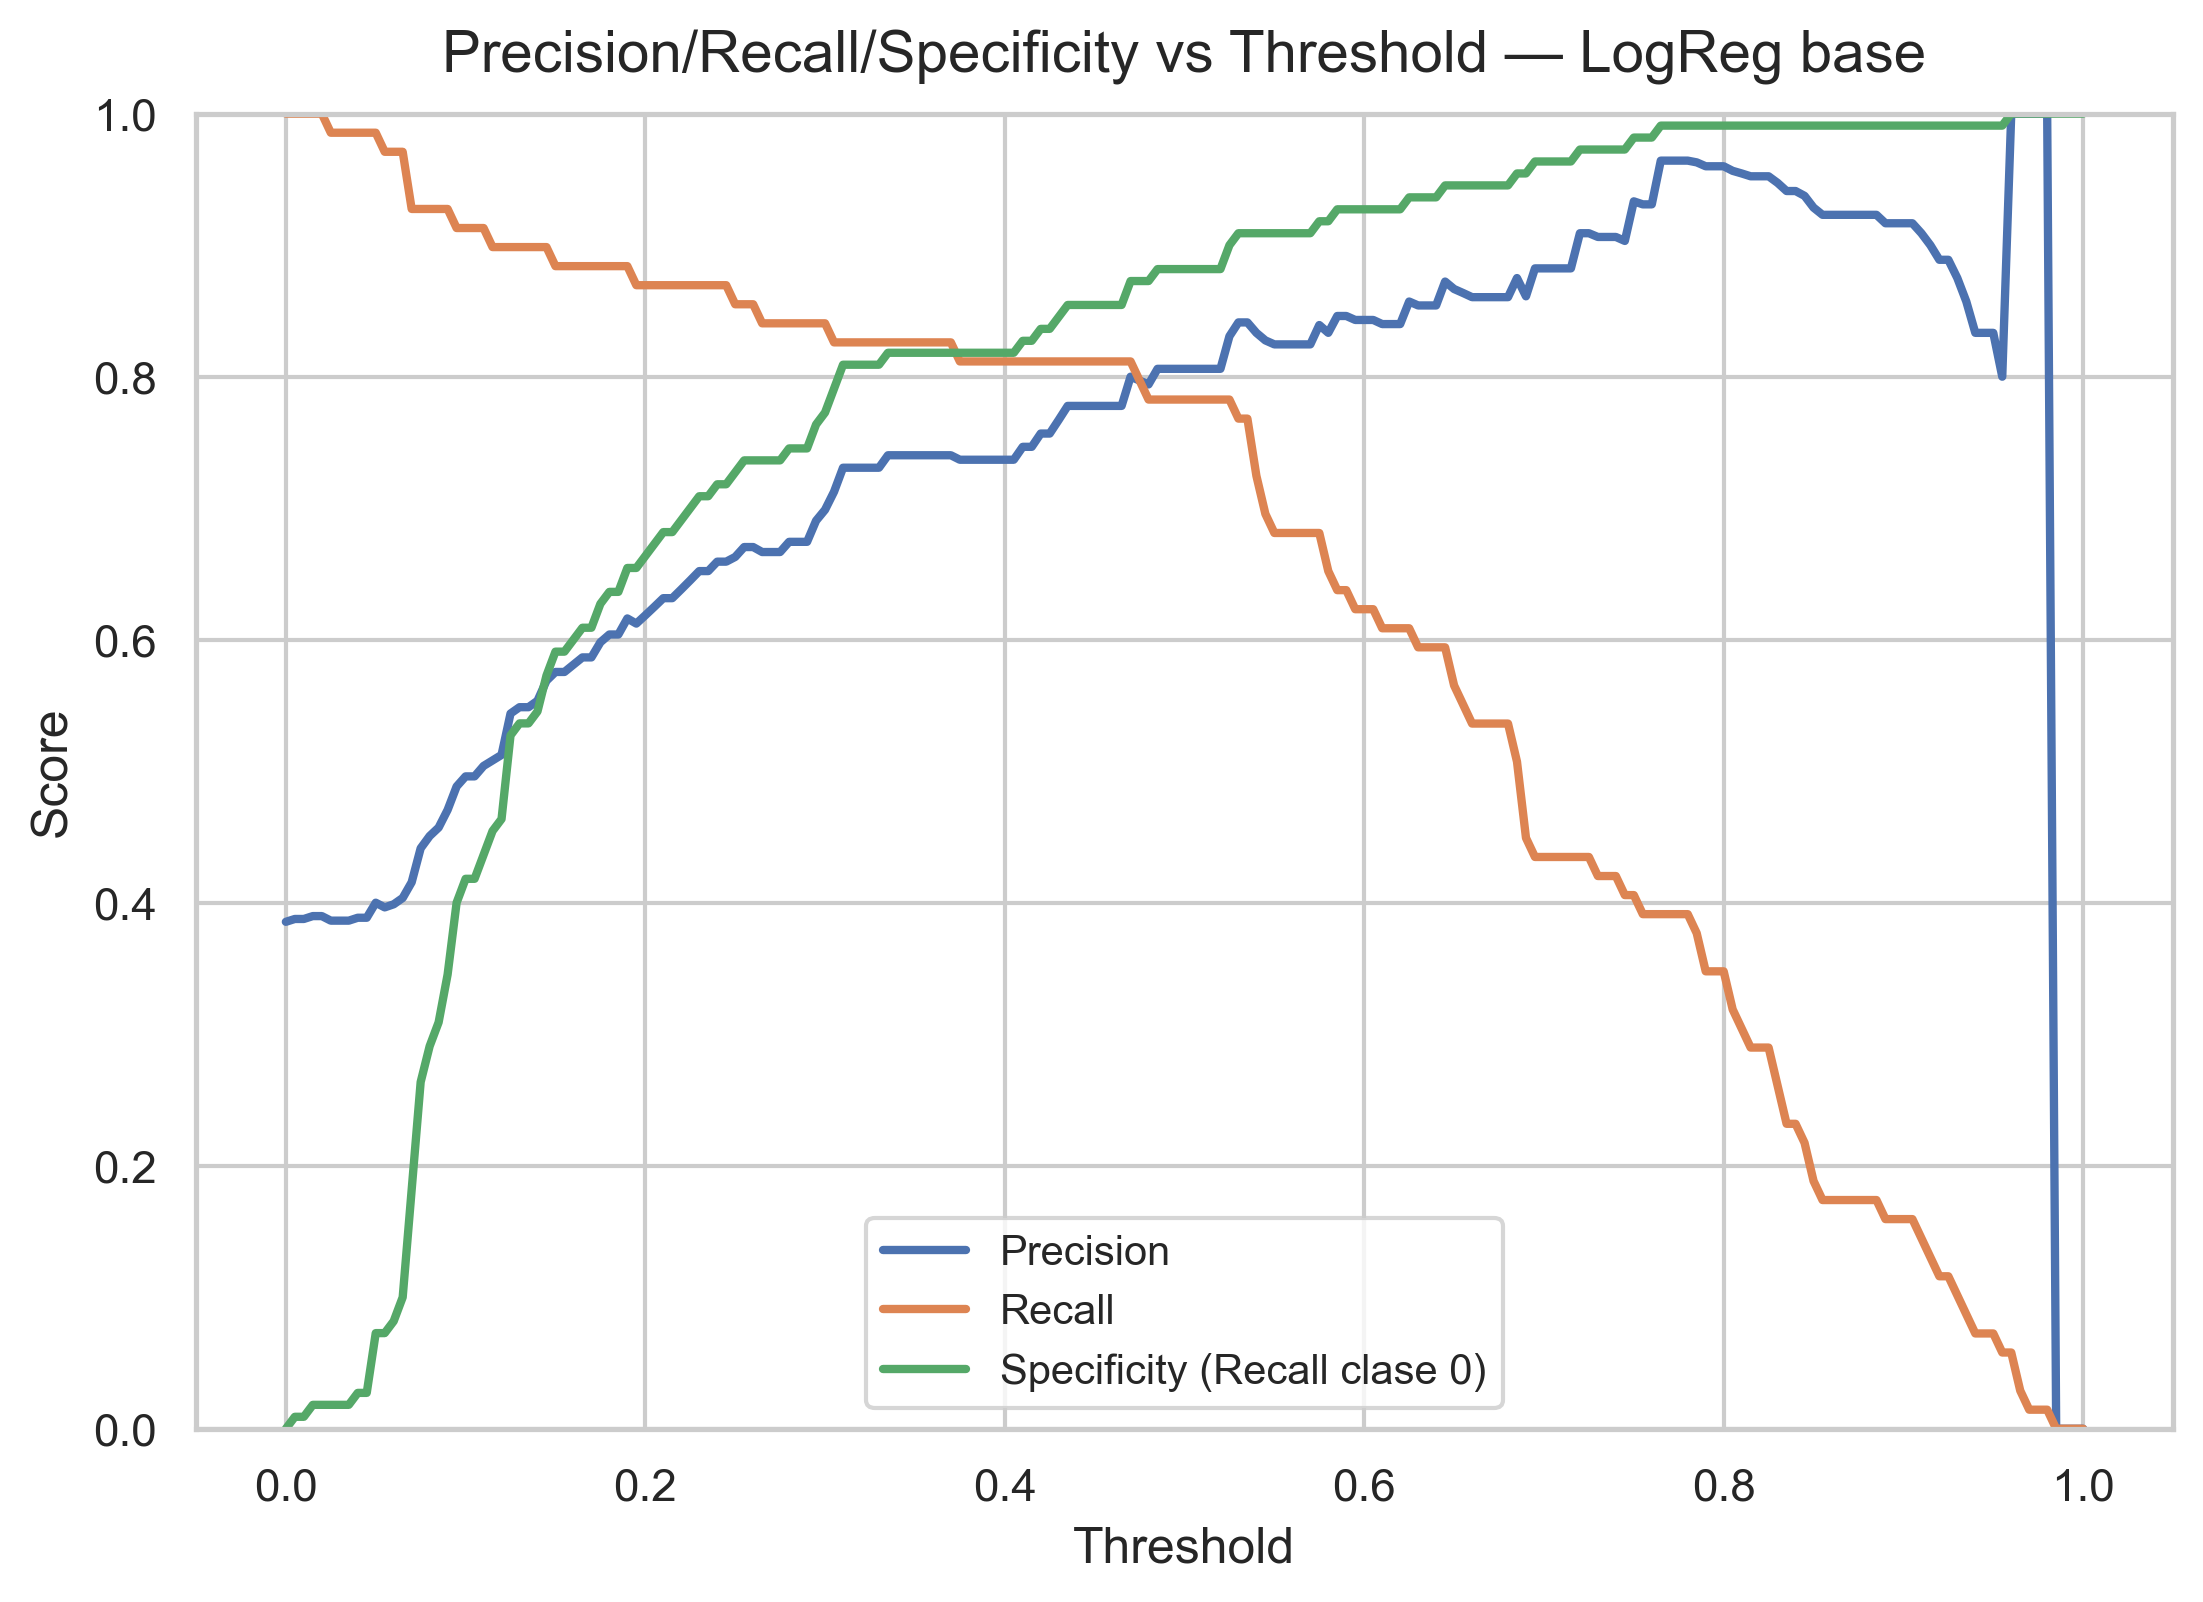

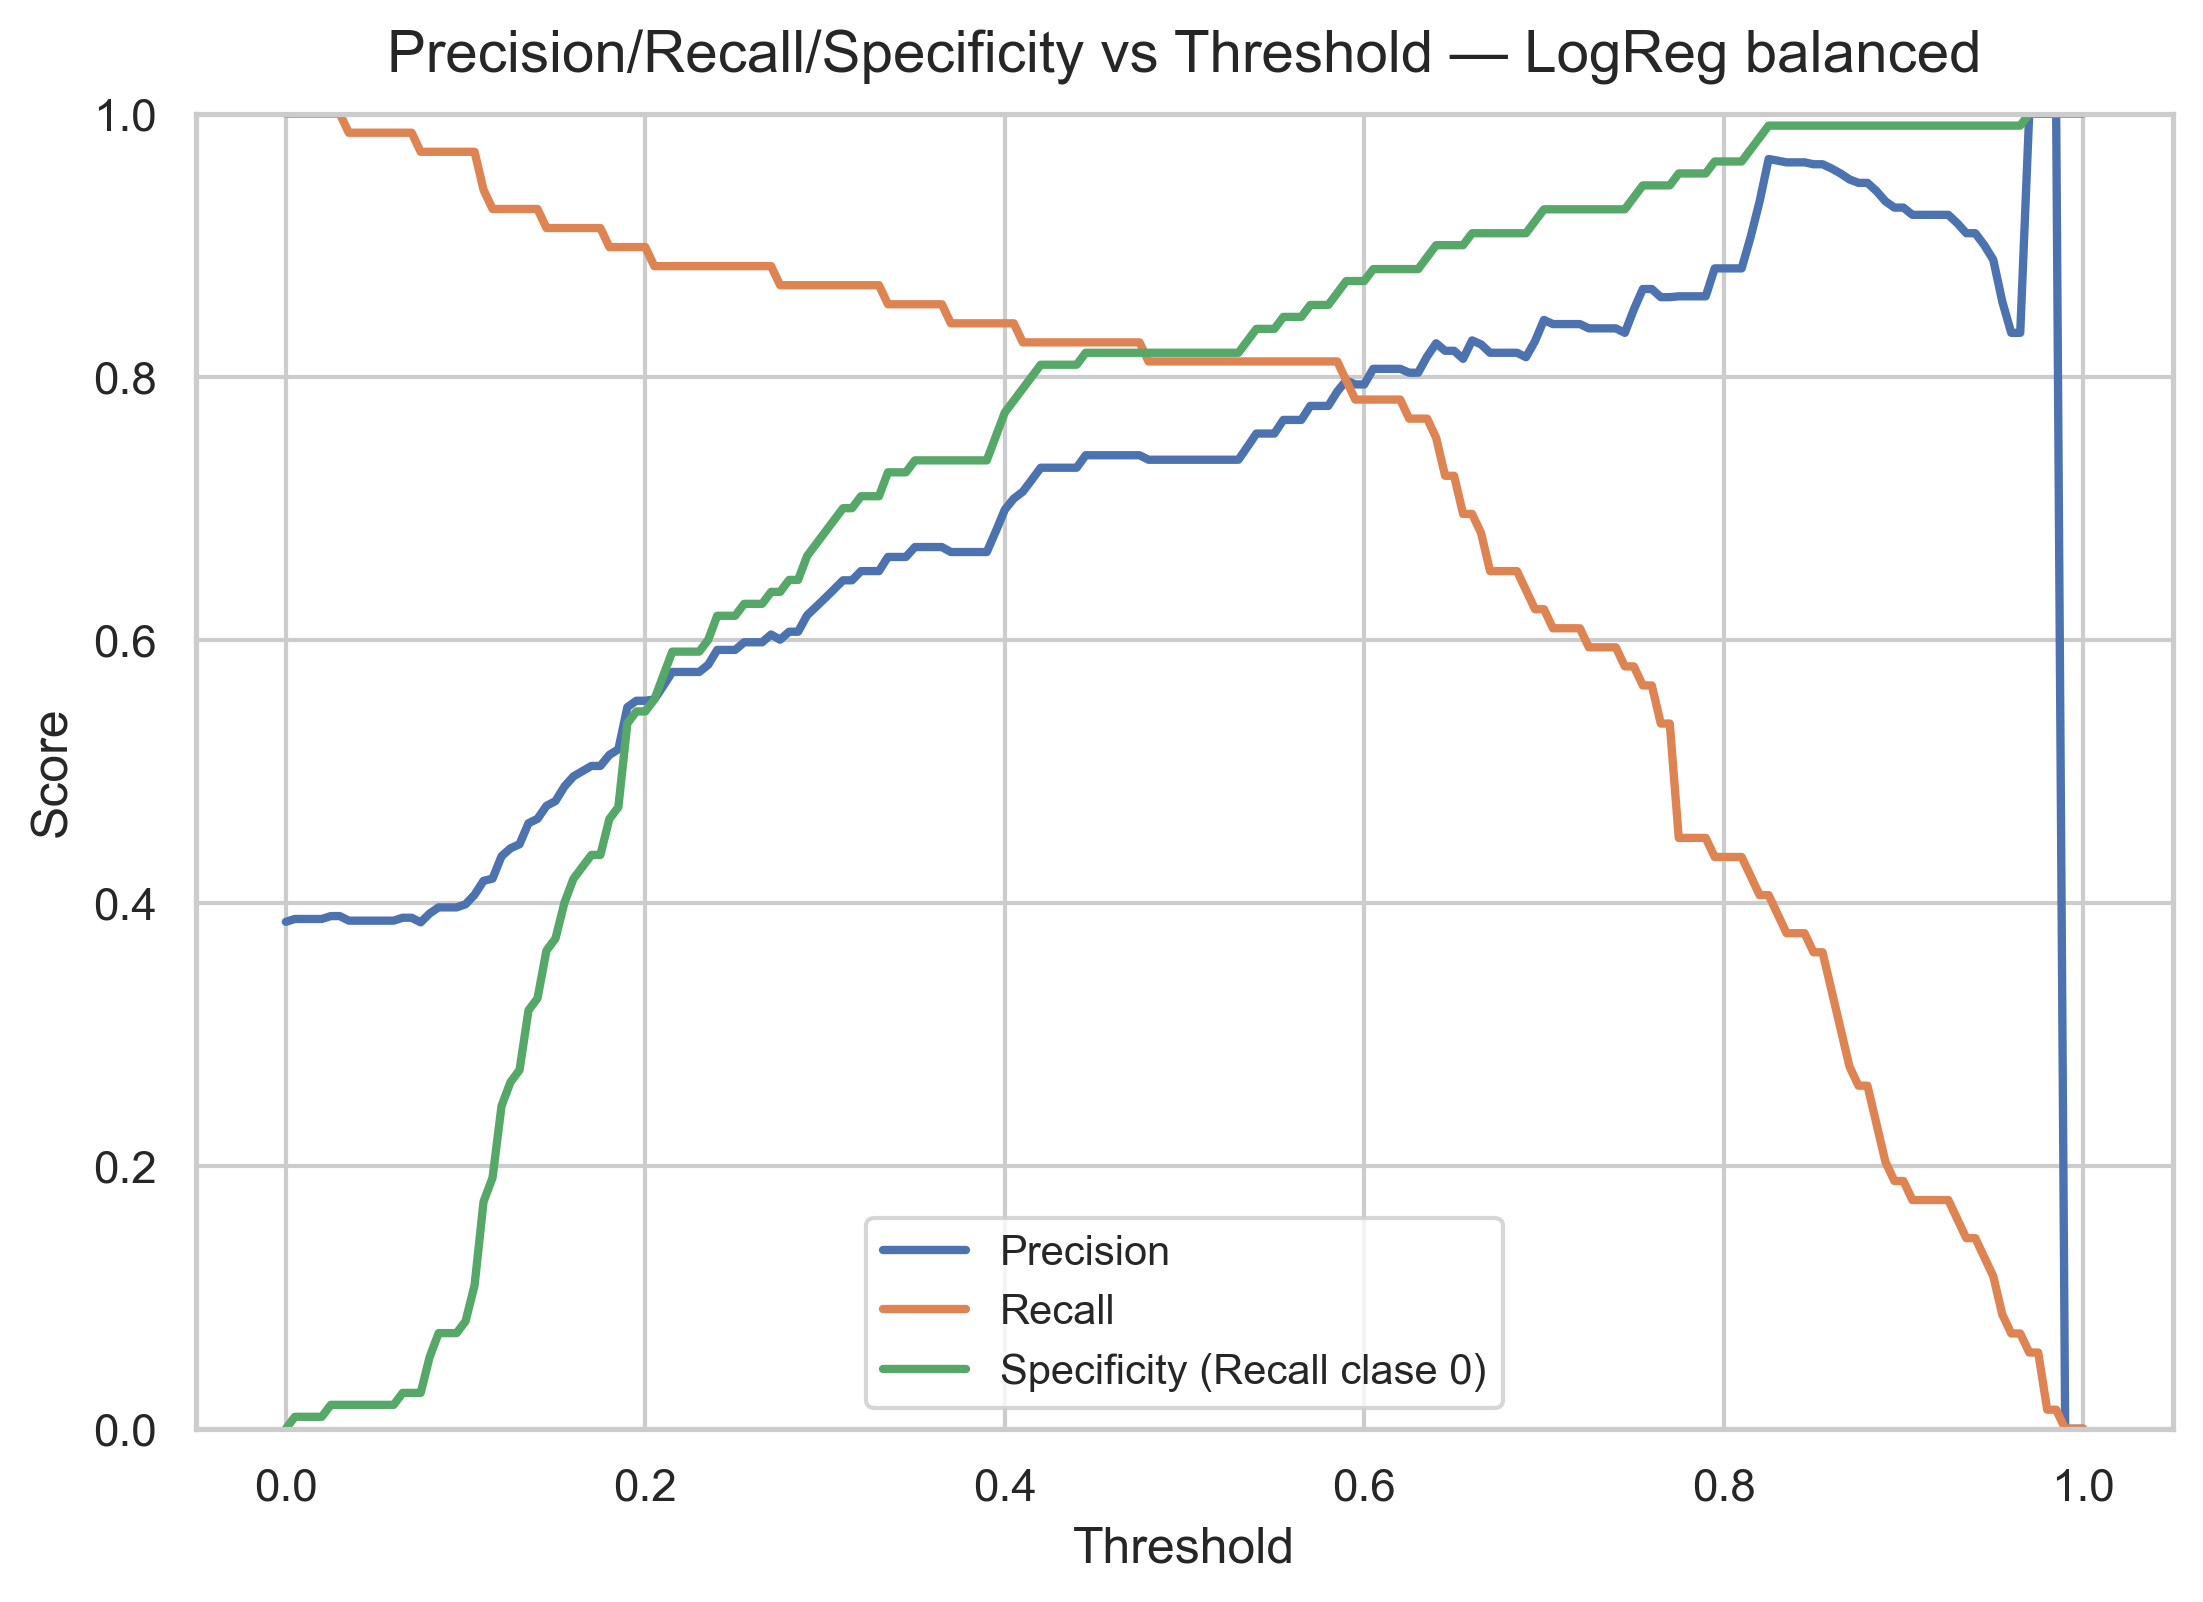

In [32]:
# PR curve (base)
pr_base_path = plot_pr_curve(
    y_test, proba_base,
    name="pr_curve_logreg_base",
    title="Curva Precision–Recall — LogReg (base)",
    caption="Relación precisión–recobrado para LogReg base en test; el área (AP) complementa al ROC-AUC en clases desbalanceadas."
)
display(Image(filename=str(pr_base_path)))

# PR curve (balanced)
pr_bal_path = plot_pr_curve(
    y_test, proba_bal,
    name="pr_curve_logreg_balanced",
    title="Curva Precision–Recall — LogReg (balanced)",
    caption="Class weighting puede desplazar la curva hacia mayor recall a costa de precisión; AP resume el cambio global."
)
display(Image(filename=str(pr_bal_path)))

# Threshold trade-off (base y balanced)
thr_base_df = sweep_thresholds(y_test, proba_base)
thr_bal_df  = sweep_thresholds(y_test, proba_bal)

trade_base_path = plot_threshold_tradeoff(
    thr_base_df, name="thr_tradeoff_logreg_base",
    title="Precision/Recall/Specificity vs Threshold — LogReg base",
    caption="Visualiza cómo cambia Precision, Recall y Specificity (clase 0) al mover el umbral."
)
display(Image(filename=str(trade_base_path)))

trade_bal_path = plot_threshold_tradeoff(
    thr_bal_df, name="thr_tradeoff_logreg_balanced",
    title="Precision/Recall/Specificity vs Threshold — LogReg balanced",
    caption="Con pesos balanceados el recall del positivo suele mejorar para thresholds similares."
)
display(Image(filename=str(trade_bal_path)))   

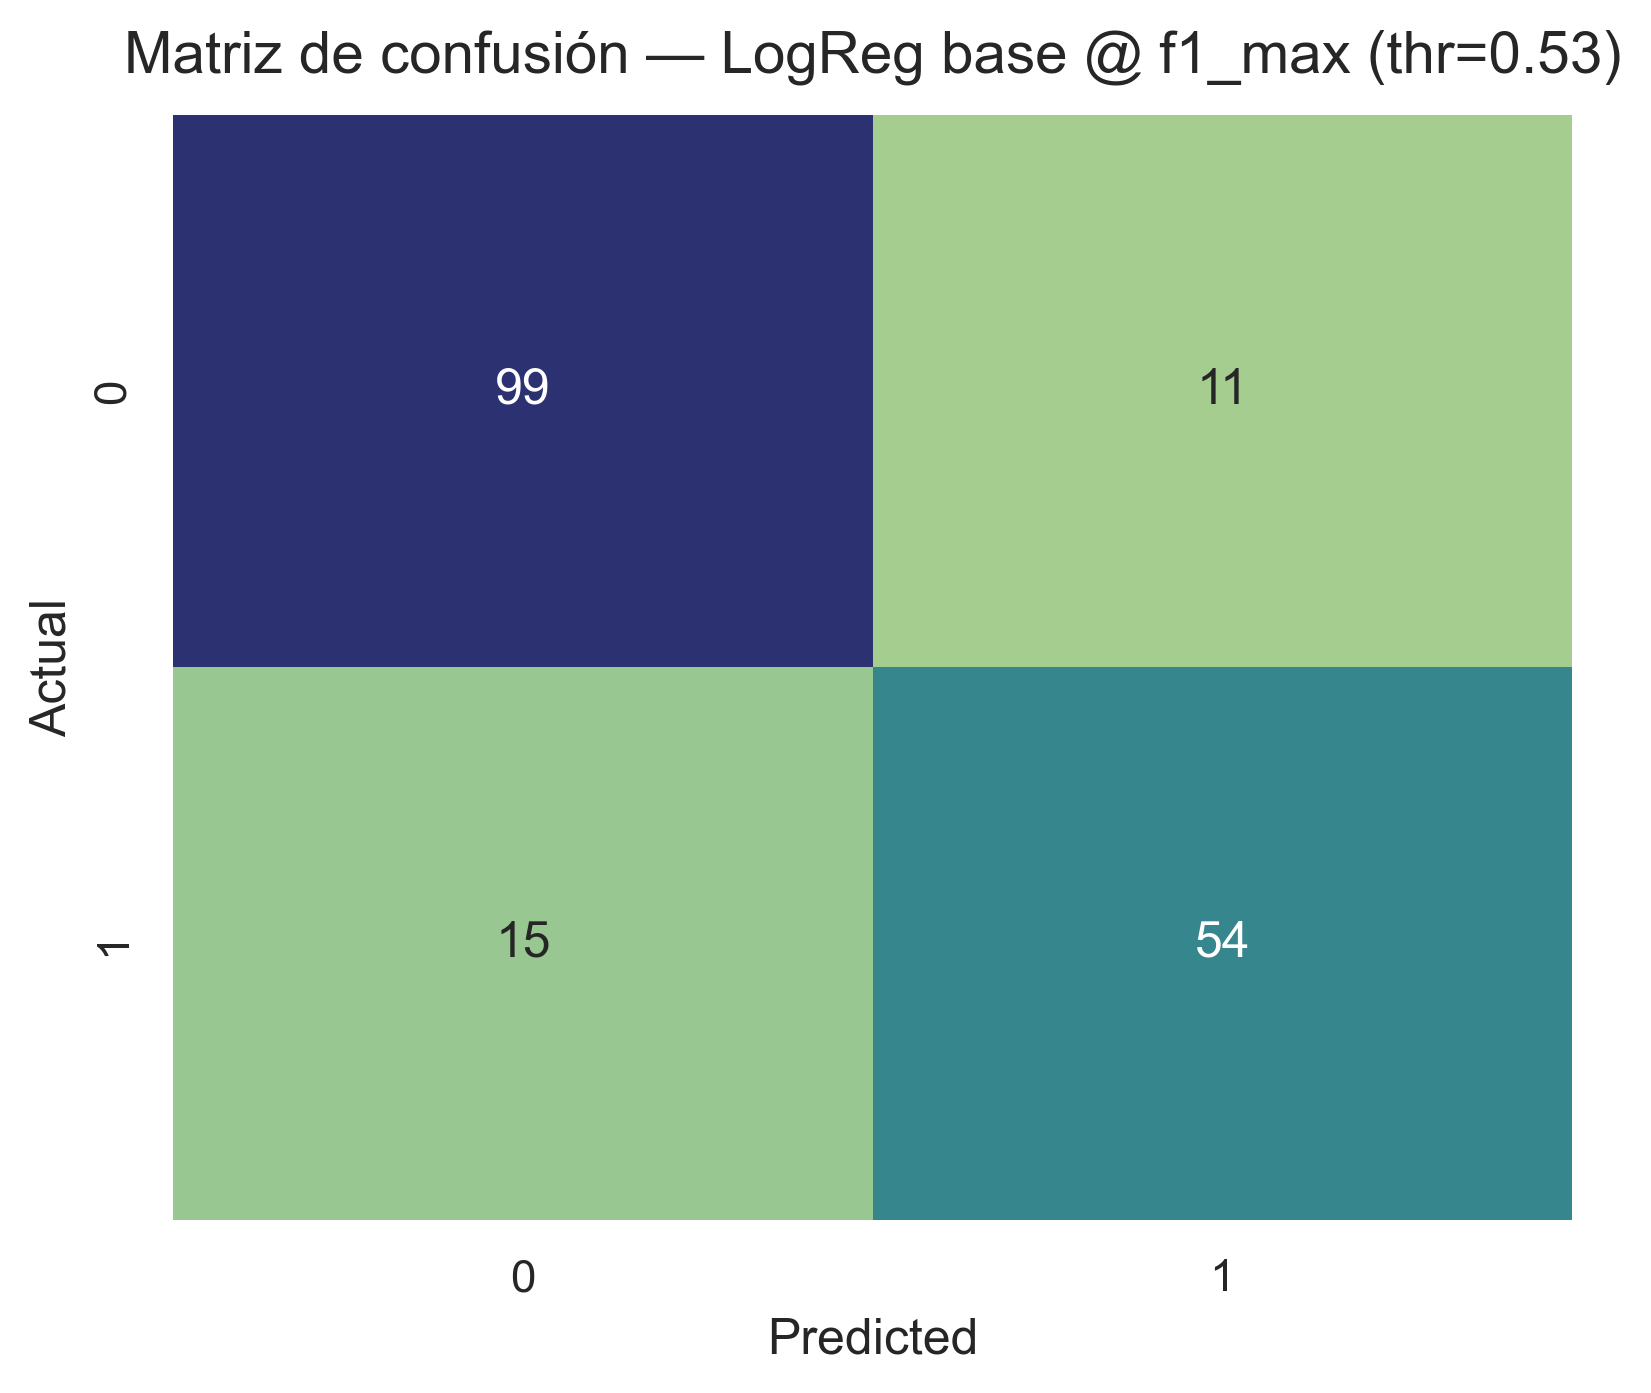

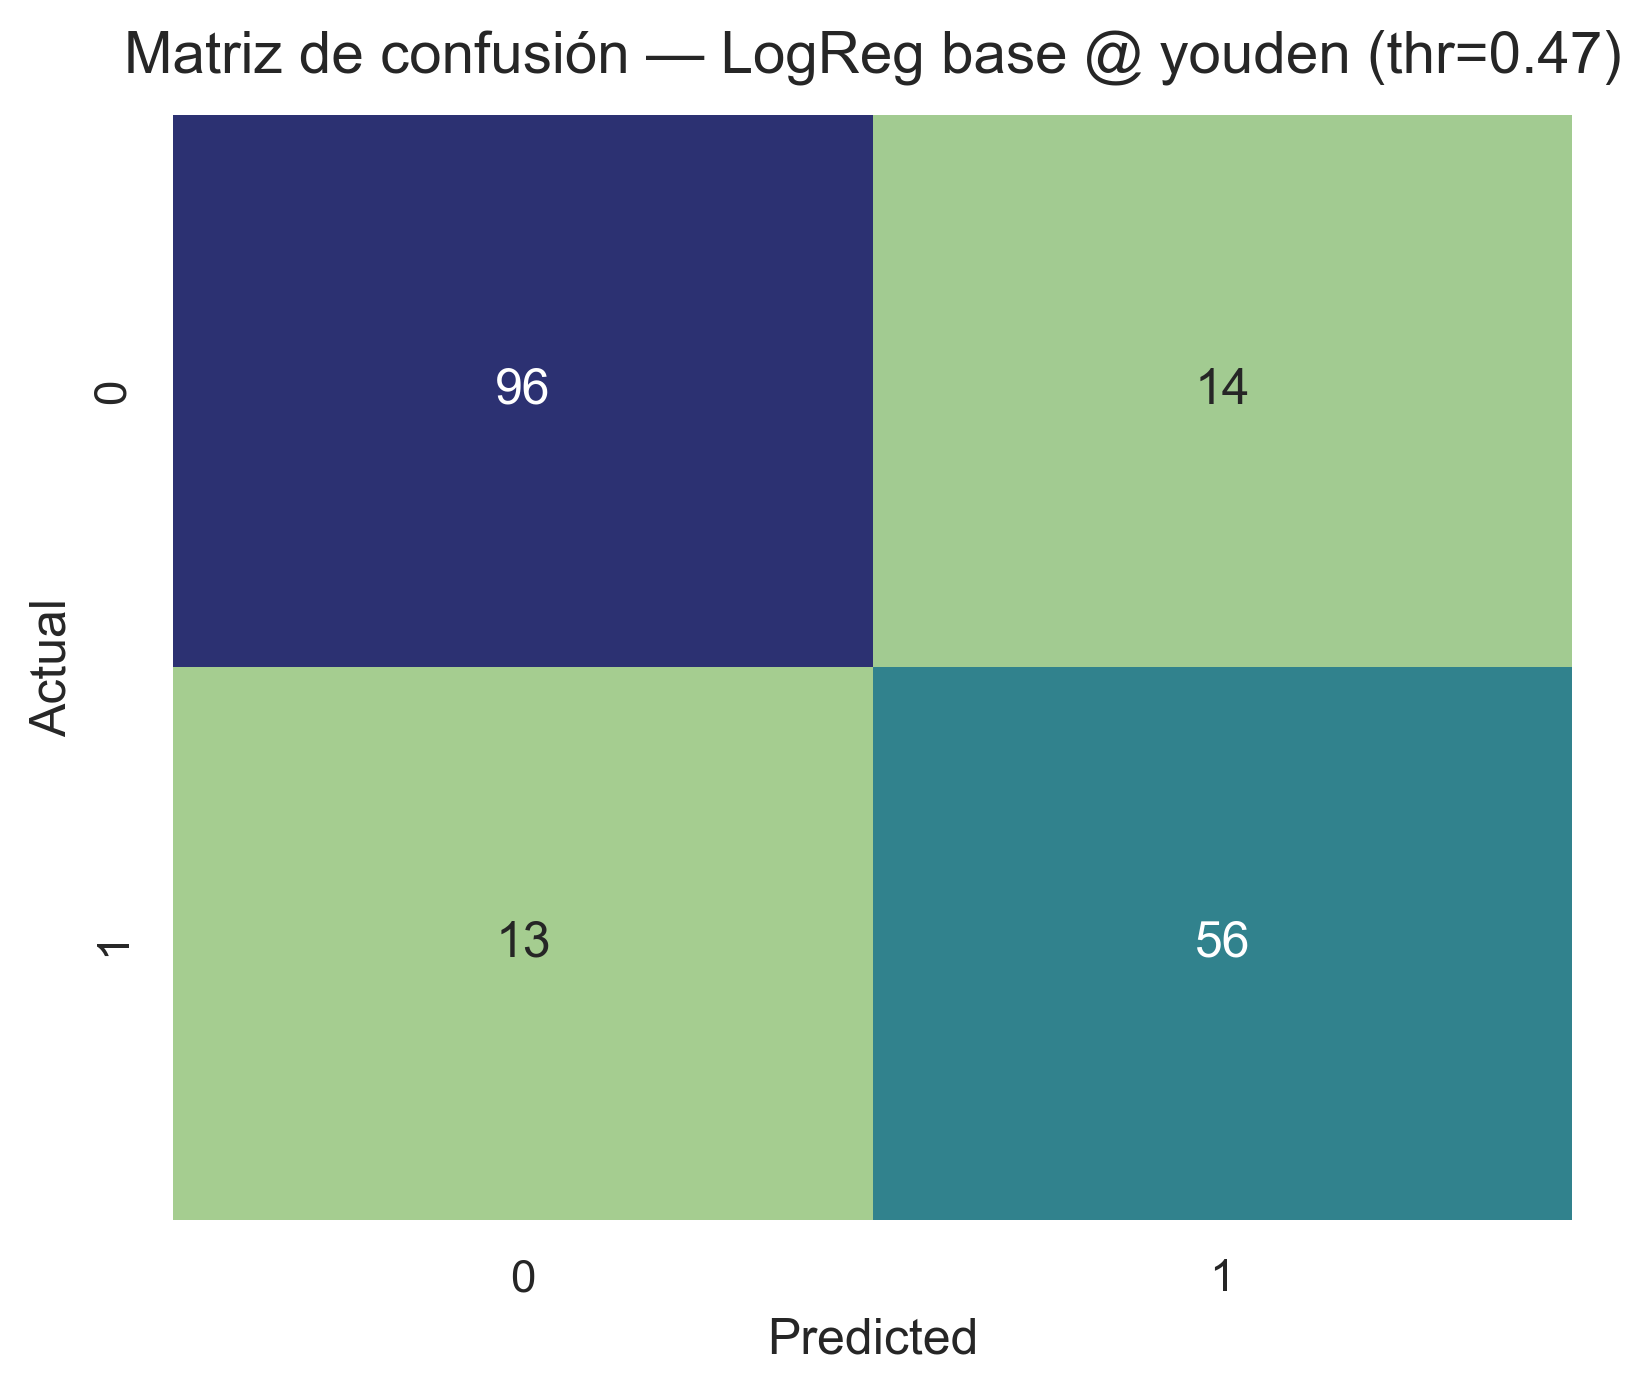

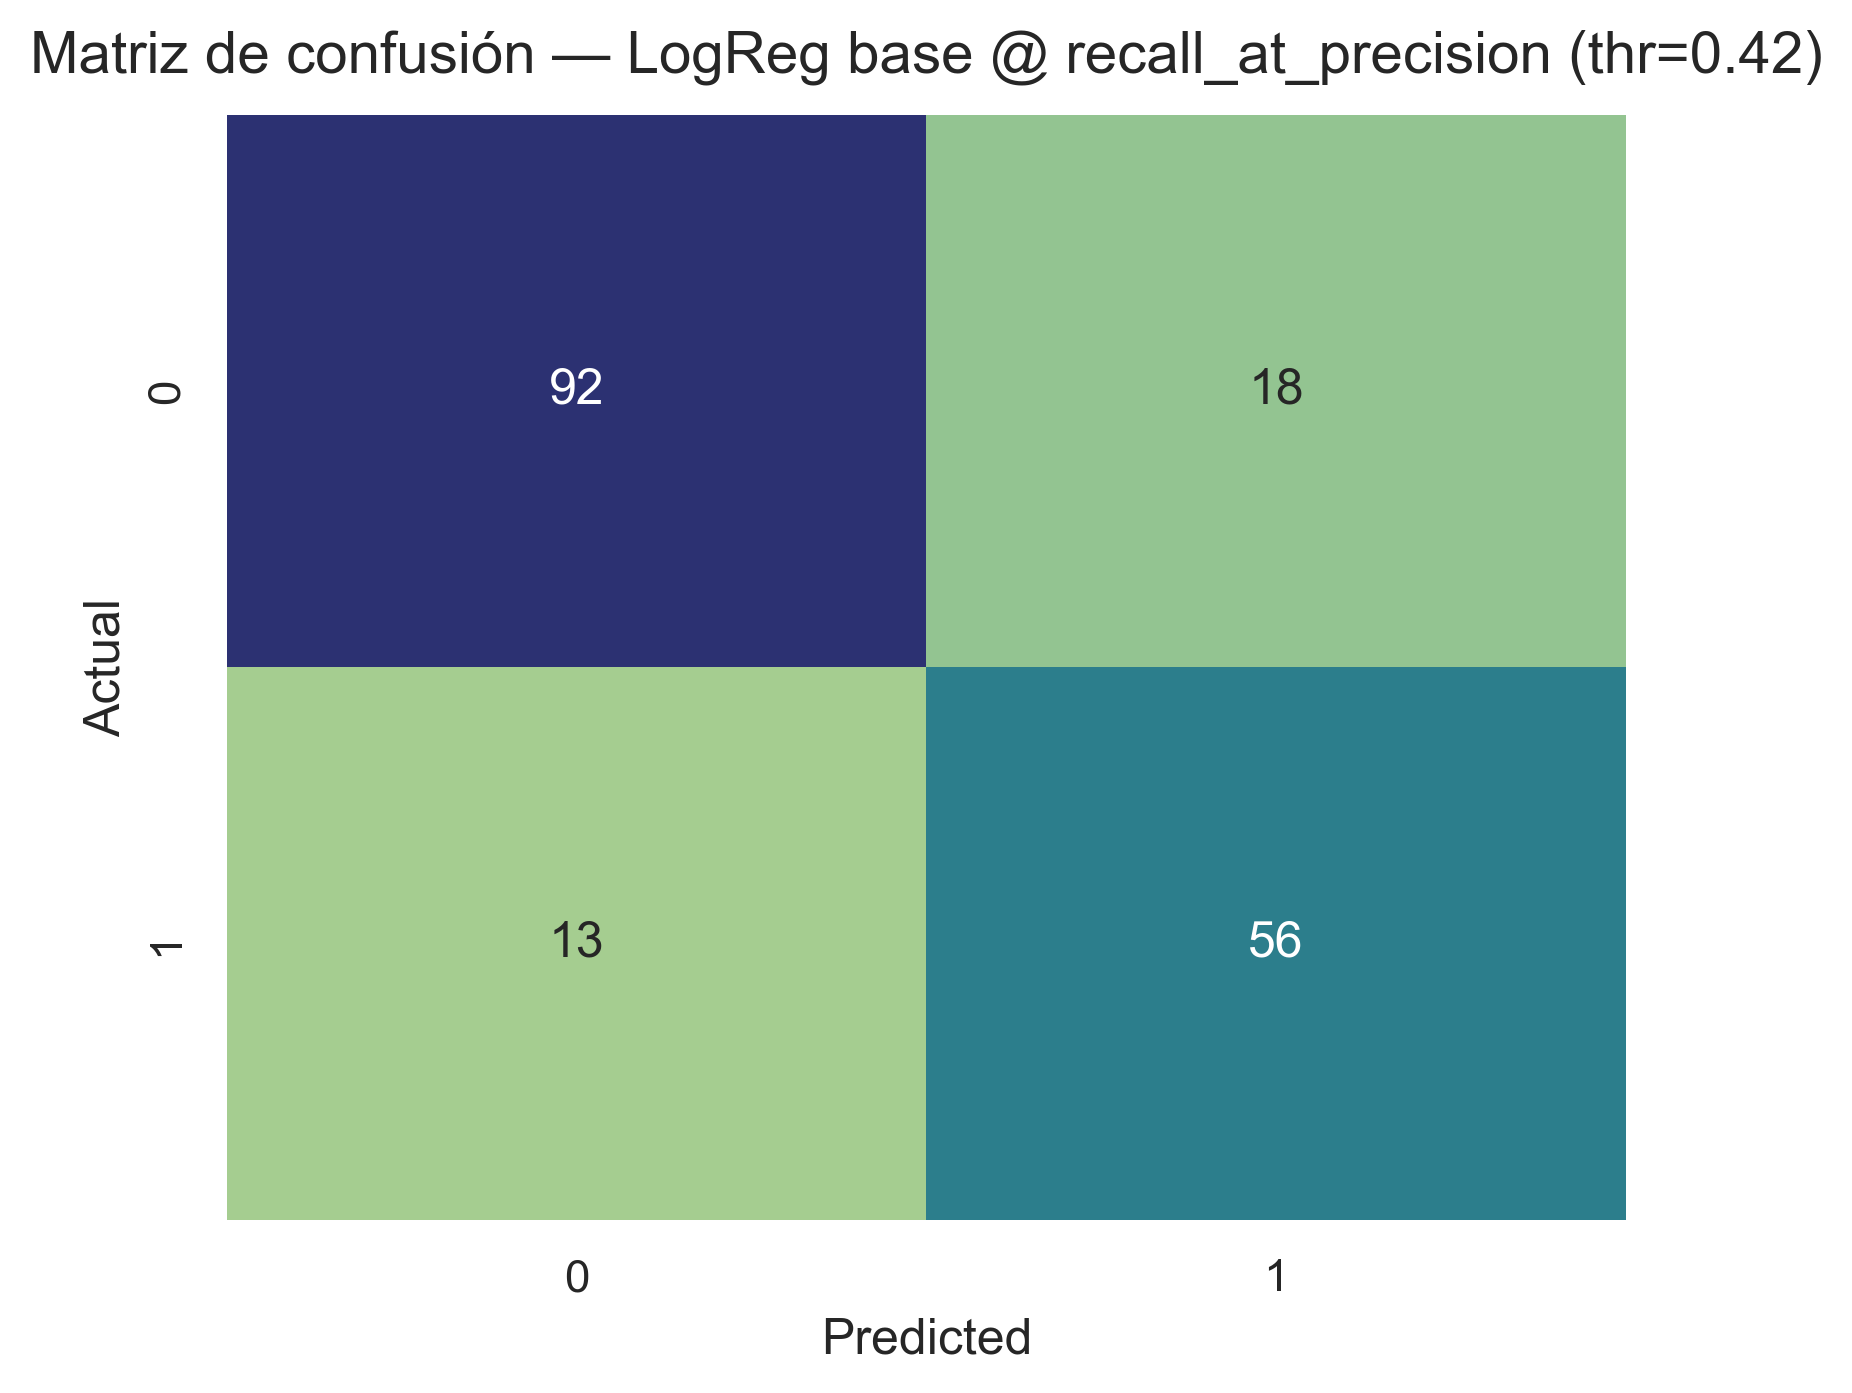

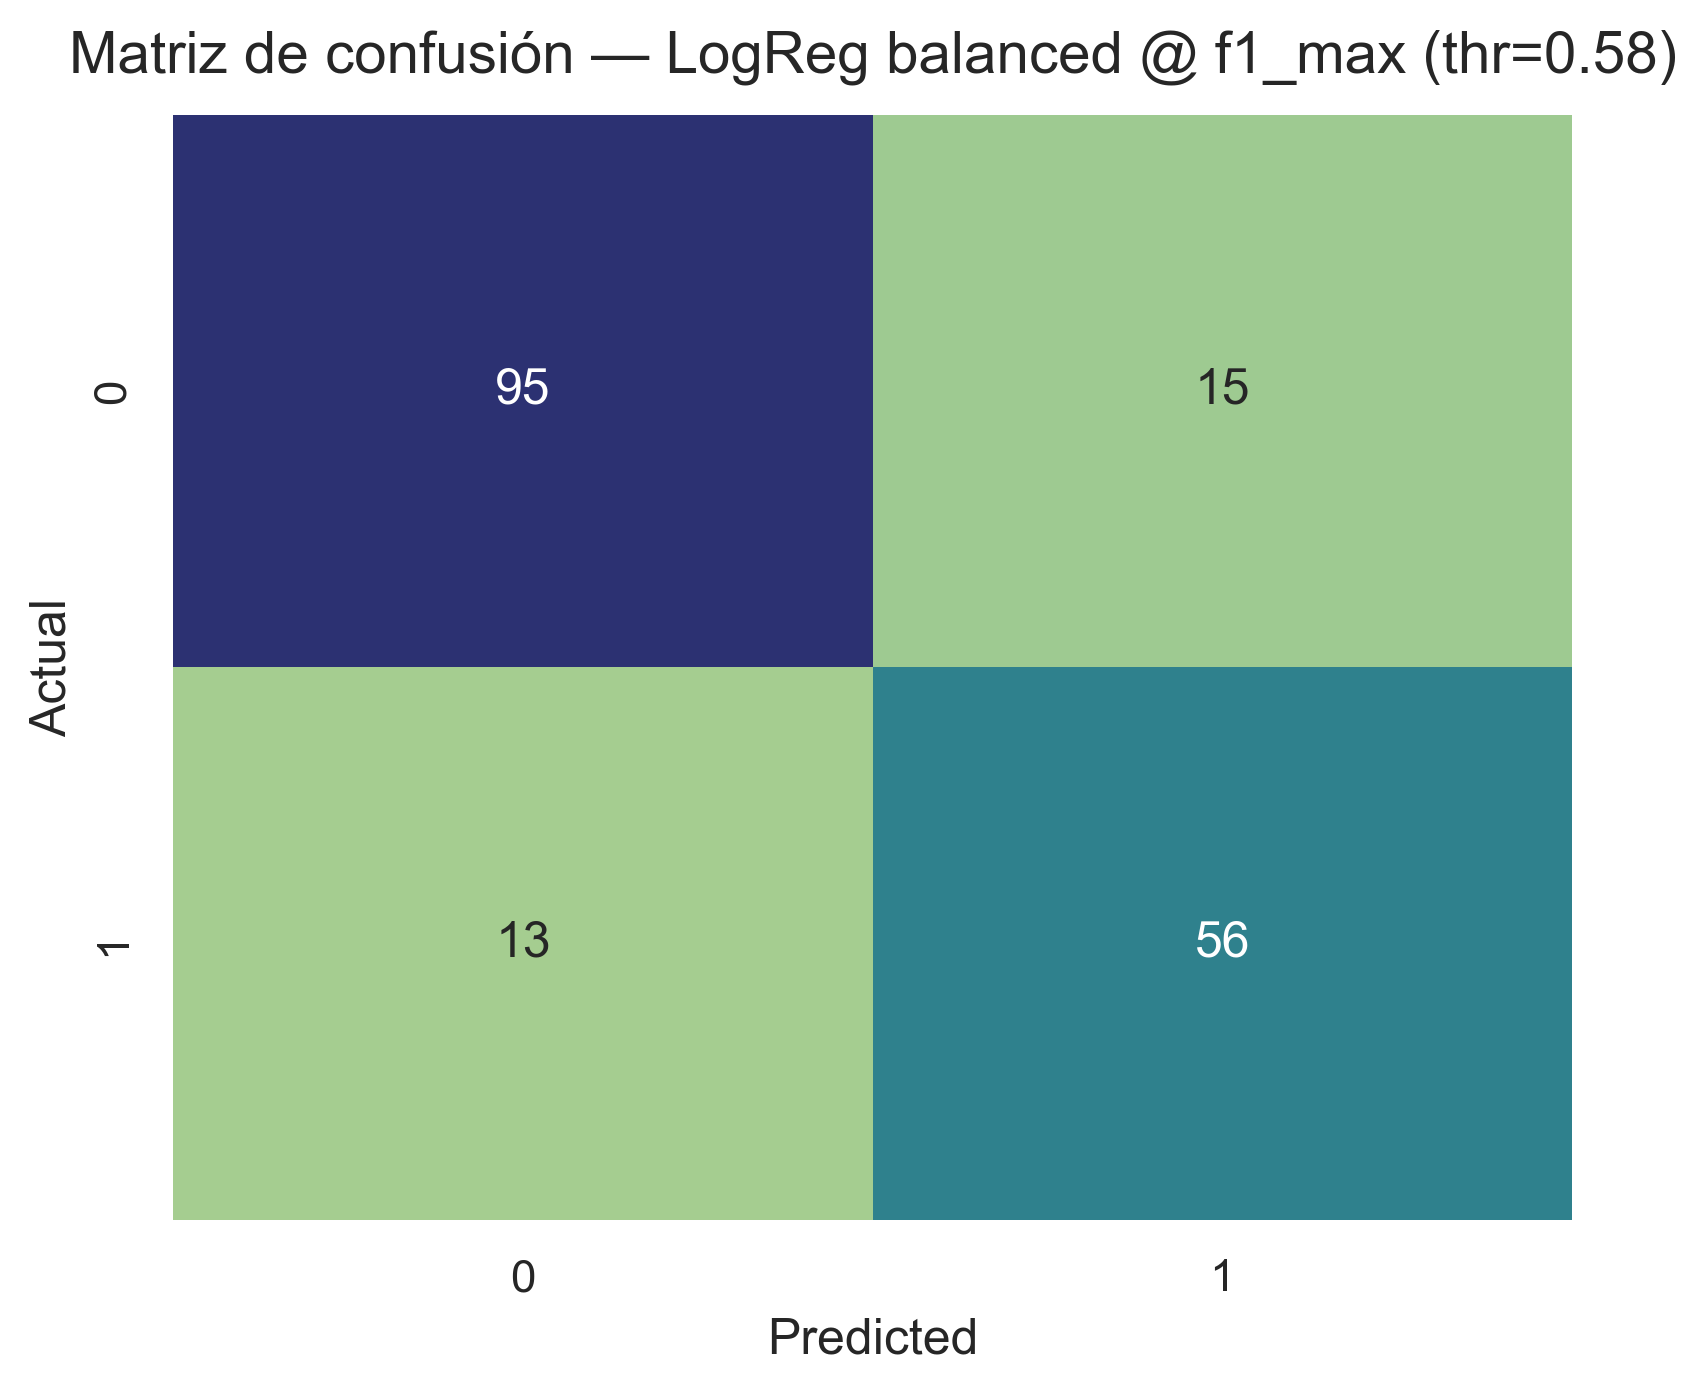

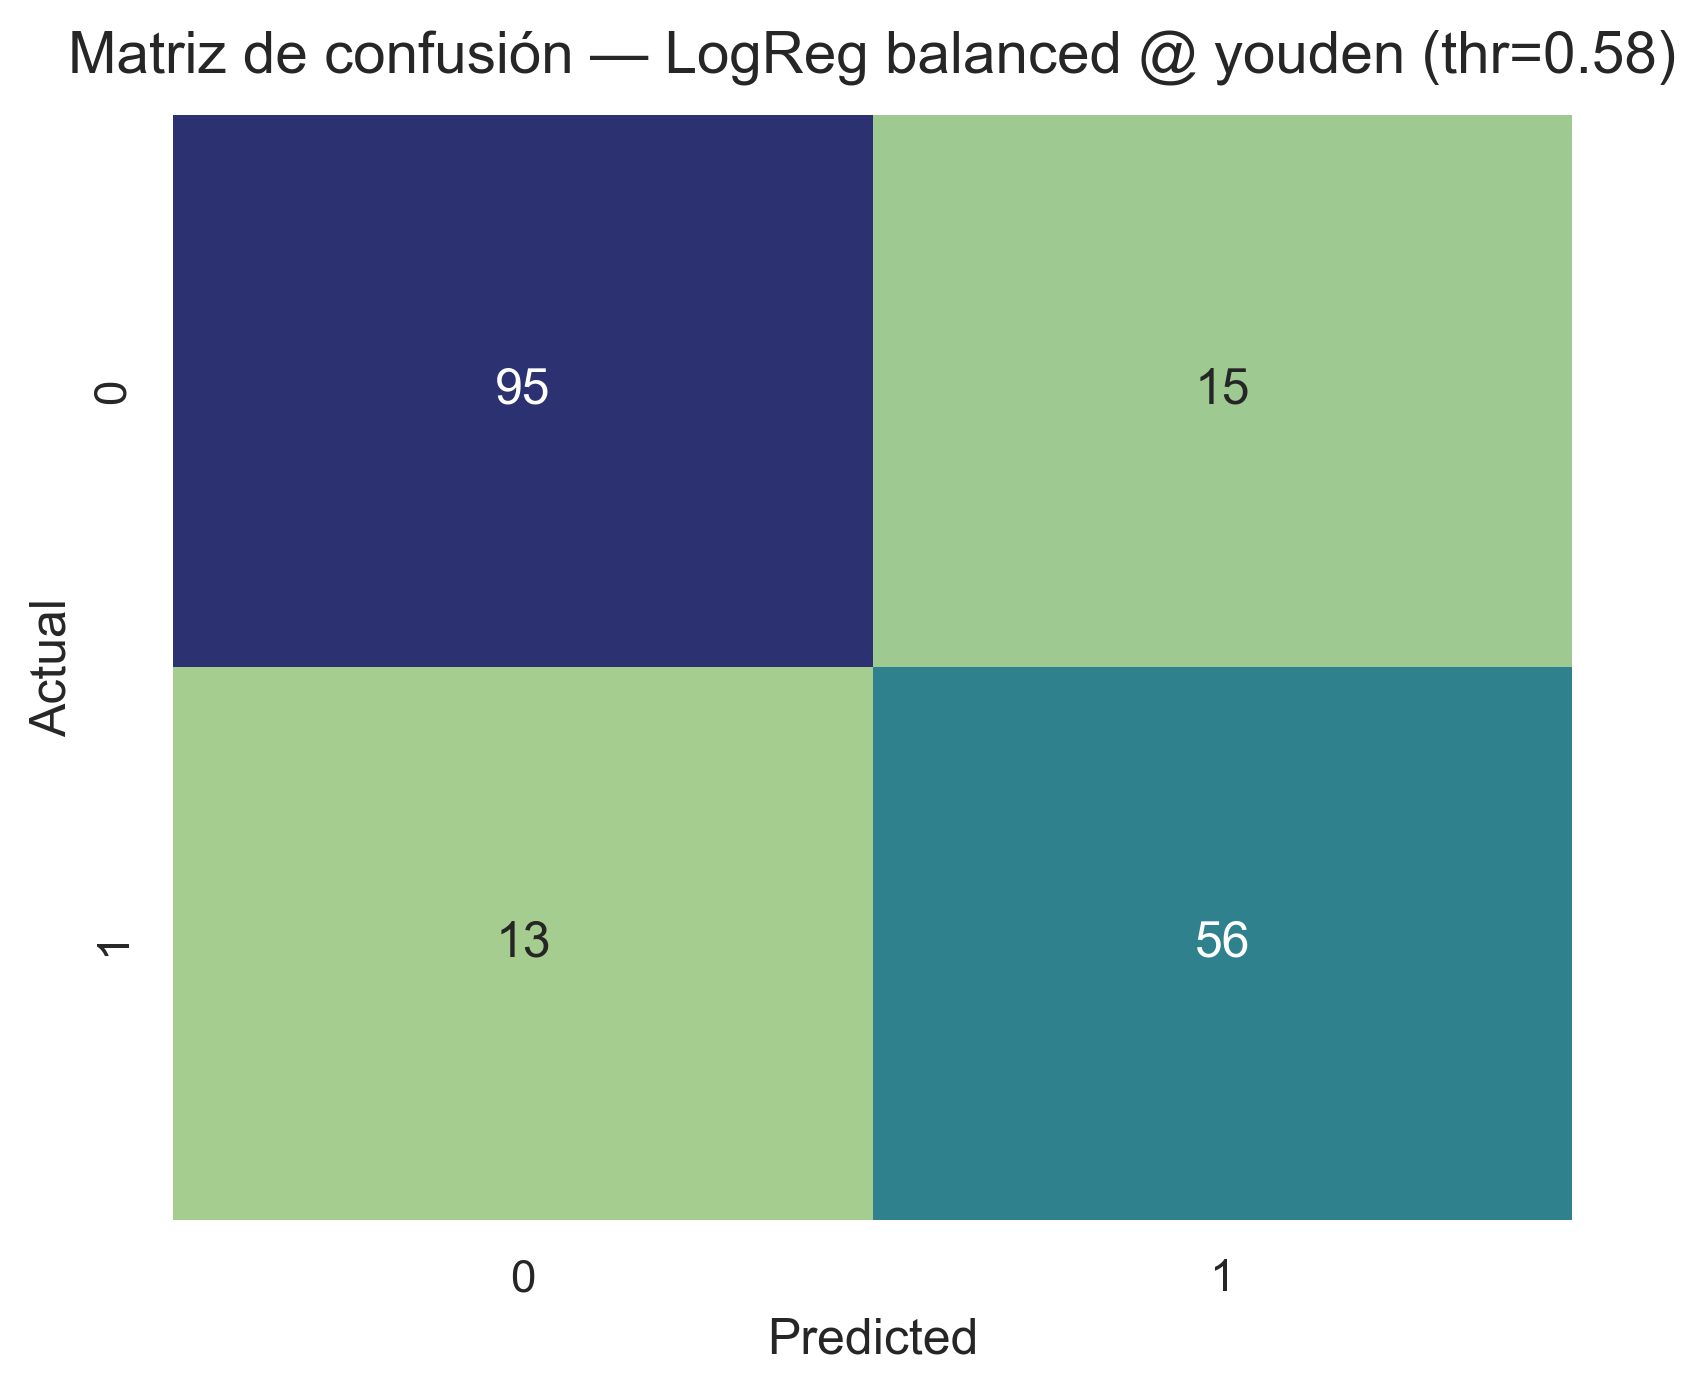

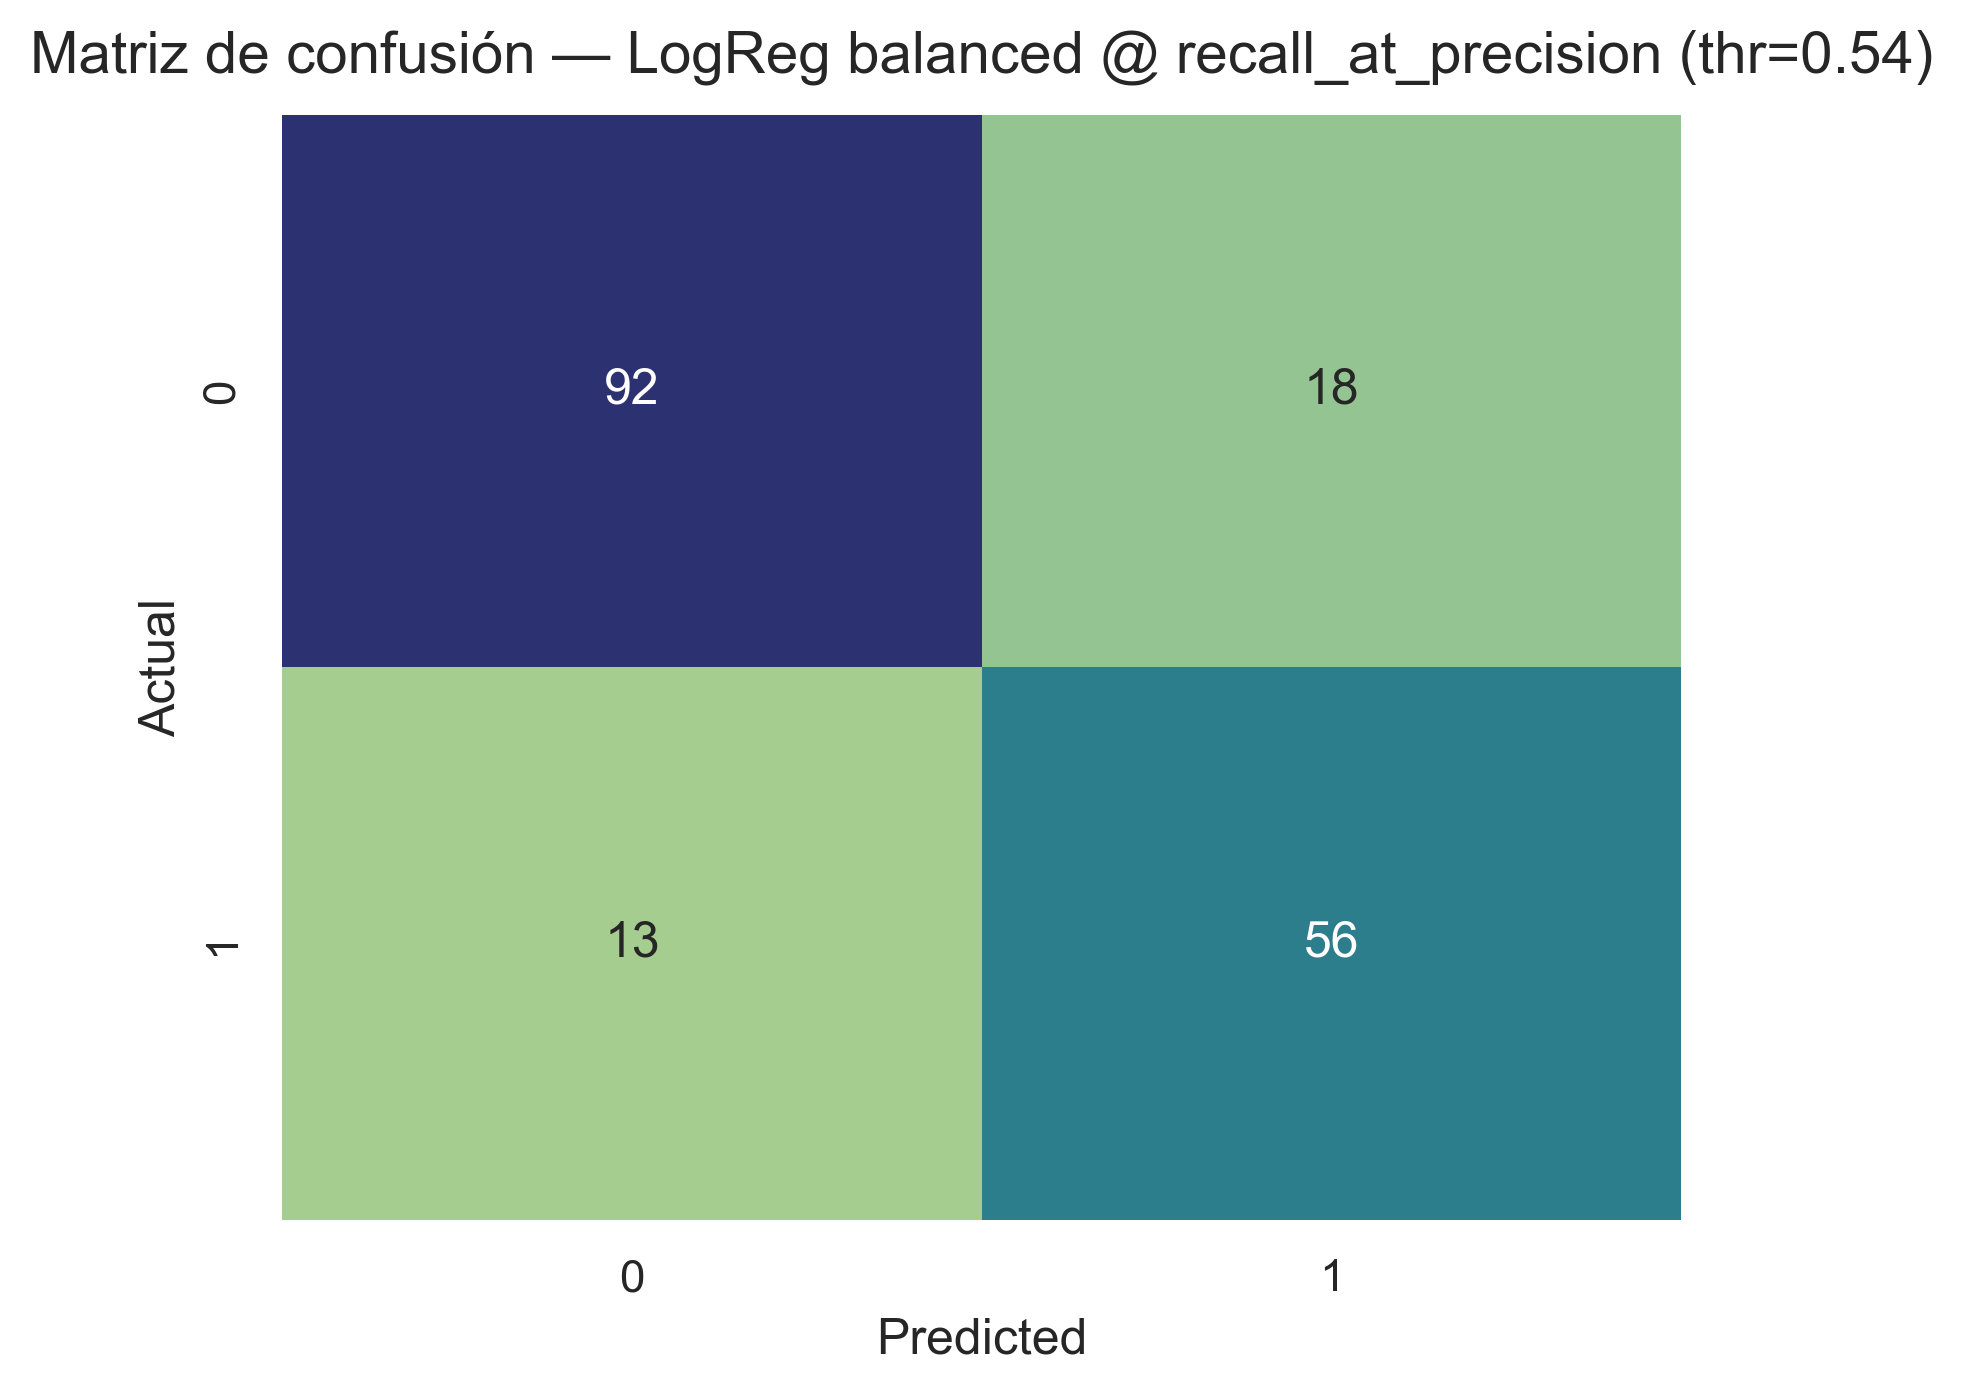

,Modelo,Operación,Threshold,Acc,Precision,Recall,Specificity,F1,ROC_AUC,PR_AUC
0,LogReg balanced,f1_max,0.585,0.844,0.789,0.812,0.864,0.800,0.858,0.827
1,LogReg balanced,recall_at_precision,0.540,0.827,0.757,0.812,0.836,0.783,0.858,0.827
2,LogReg balanced,youden,0.585,0.844,0.789,0.812,0.864,0.800,0.858,0.827
3,LogReg base,f1_max,0.525,0.855,0.831,0.783,0.900,0.806,0.862,0.828
4,LogReg base,recall_at_precision,0.420,0.827,0.757,0.812,0.836,0.783,0.862,0.828
5,LogReg base,youden,0.470,0.849,0.800,0.812,0.873,0.806,0.862,0.828


In [33]:
# Elección de umbrales “operativos”
picks_base = choose_thresholds(y_test, proba_base, min_precision=0.75)
picks_bal  = choose_thresholds(y_test, proba_bal,  min_precision=0.75)

def _mk_cm_and_row(tag, picks, y_true, y_proba):
    rows = []
    cm_paths = {}
    for key, rec in picks.items():
        thr = float(rec["threshold"])
        m = metrics_from_threshold(y_true, y_proba, thr)
        # Matriz
        cm = np.array([[m["tn"], m["fp"]],[m["fn"], m["tp"]]])
        path_cm = plot_confusion_matrix(
            cm, labels=["0","1"],
            name=f"cm_logreg_{tag}_{key}",
            title=f"Matriz de confusión — LogReg {tag} @ {key} (thr={thr:.2f})",
            caption=f"Operación '{key}' con threshold={thr:.2f}: precisión={m['precision']:.2f}, recall={m['recall']:.2f}, specificity={m['specificity']:.2f}."
        )
        display(Image(filename=str(path_cm)))
        cm_paths[key] = str(path_cm)
        row = {
            "Modelo": f"LogReg {tag}",
            "Operación": key,
            "Threshold": thr,
            "Acc": m["accuracy"], "Precision": m["precision"], "Recall": m["recall"],
            "Specificity": m["specificity"], "F1": m["f1"],
            "ROC_AUC": m["roc_auc"], "PR_AUC": m["pr_auc"]
        }
        rows.append(row)
    return rows, cm_paths

rows_base, cm_base = _mk_cm_and_row("base", picks_base, y_test, proba_base)
rows_bal, cm_bal  = _mk_cm_and_row("balanced", picks_bal, y_test, proba_bal)

df_op = pd.DataFrame(rows_base + rows_bal).sort_values(["Modelo","Operación"]).reset_index(drop=True)
op_tbl_path = save_metrics_table(
    df_op.round(3), name="table_logreg_operating_points",
    description="LogReg base vs balanced en tres esquemas de umbral: F1 máximo, Youden J y Recall@Precision≥0.75."
)
display(df_op.round(3))

In [34]:
# Tomamos F1_max como “operación por defecto” para la comparativa compacta
def _pick(df, modelo_tag, oper):
    r = df[(df["Modelo"]==modelo_tag) & (df["Operación"]==oper)].copy()
    return r

comp = pd.concat([
    _pick(df_op, "LogReg base", "f1_max"),
    _pick(df_op, "LogReg balanced", "f1_max")
], ignore_index=True)

comp_tbl_path = save_metrics_table(
    comp.round(3), name="table_logreg_base_vs_balanced_f1max",
    description="Comparación compacta LogReg base vs balanced usando umbral que maximiza F1."
)
display(comp.round(3))

,Modelo,Operación,Threshold,Acc,Precision,Recall,Specificity,F1,ROC_AUC,PR_AUC
0,LogReg base,f1_max,0.525,0.855,0.831,0.783,0.900,0.806,0.862,0.828
1,LogReg balanced,f1_max,0.585,0.844,0.789,0.812,0.864,0.800,0.858,0.827


In [35]:
# Entrenar modelo final (full data) y guardar
import json
import joblib
import numpy as np
import pandas as pd
from pathlib import Path

from src.utils import p, read_csv, ensure_dirs
from src.preprocessing import build_preprocessing_pipeline
from sklearn.linear_model import LogisticRegression

# 1) Cargar datos completos
DATA_RAW = p("data", "raw", "Titanic-Dataset.csv")
df_full = read_csv(DATA_RAW)
target_col = [c for c in df_full.columns if c.lower() == "survived"][0]
y_full = df_full[target_col].astype(int).values

# 2) (Re)construir y ajustar el preprocesamiento en TODO el dataset
preproc_full = build_preprocessing_pipeline(df_full)
preproc_full.fit(df_full)
X_full = preproc_full.transform(df_full)

# 3) Entrenar el modelo final (LogReg base)
logreg_final = LogisticRegression(max_iter=2000, solver="lbfgs")
logreg_final.fit(X_full, y_full)

# 4) Guardar pipeline + modelo en un solo artefacto
ensure_dirs()
models_dir = p("models")
models_dir.mkdir(parents=True, exist_ok=True)

MODEL_PKL = models_dir / "best_model.pkl"
joblib.dump({
    "preprocessor": preproc_full,
    "model": logreg_final,
    "threshold": 0.525,  # Umbral elegido por F1-máx en test
    "model_name": "LogisticRegression_base",
    "notes": "Entrenado en todo el dataset con pipeline completo; umbral de decisión fijado por F1-máx observado."
}, MODEL_PKL)

# 5) Guardar metadatos legibles (JSON)
META_JSON = models_dir / "best_model_meta.json"
meta = {
    "model_artifact": str(MODEL_PKL),
    "model_name": "LogisticRegression_base",
    "threshold": 0.525,
    "training_data": {
        "samples": int(X_full.shape[0]),
        "features": int(X_full.shape[1])
    },
    "metrics_reference": {
        "selection_basis": "F1-máx en test (equilibrio)",
        "expected_behavior": "Equilibrio precision/recall; buena especificidad"
    }
}
META_JSON.write_text(json.dumps(meta, ensure_ascii=False, indent=2), encoding="utf-8")

print("Modelo final guardado en:", MODEL_PKL)
print("Metadatos en:", META_JSON)

Modelo final guardado en: C:\Users\luigu\OneDrive\Escritorio\Titanic_MLProject\models\best_model.pkl
Metadatos en: C:\Users\luigu\OneDrive\Escritorio\Titanic_MLProject\models\best_model_meta.json
